# Profiling `malca.events` on SkyPatrol light curves

Use `cProfile` to time the Bayesian event scorer on real SkyPatrol CSVs stored in `input/skypatrol2`. The notebook keeps everything self contained so it can run directly against the repo without extra setup.

## Environment setup

Locate the repo root, add it to `sys.path`, and collect the SkyPatrol CSVs we'll profile.

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

# Find repo root whether the notebook is run from notebooks/ or repo root
candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
repo_root = next((p for p in candidates if (p / "malca").exists()), Path.cwd())

for path in (repo_root, repo_root / "malca"):
    sp = str(path.resolve())
    if sp not in sys.path:
        sys.path.insert(0, sp)

data_dir = repo_root / "input" / "skypatrol2"
lc_paths = sorted(data_dir.glob("*-light-curves.csv"))

print(f"Repo root: {repo_root}")
print(f"Found {len(lc_paths)} light curves in {data_dir}")
if not lc_paths:
    raise FileNotFoundError("No SkyPatrol CSVs found; adjust data_dir above.")

Repo root: /home/calder/code/malca
Found 28 light curves in /home/calder/code/malca/input/skypatrol2


## Quick peek at one SkyPatrol light curve

Read a single CSV to confirm the loader works and to see the columns that flow into the scorer.

In [2]:
from malca.plot import read_skypatrol_csv

example_path = lc_paths[0]
df_example = read_skypatrol_csv(example_path)
print(f"{example_path.name}: {len(df_example)} rows")
display(df_example.head())

120259184943-light-curves.csv: 1970 rows


,JD,flux,flux_error,mag,error,limit,fwhm,filter_band,quality_flag,camera,camera#,cam_field,good_bad,saturated,v_g_band
0,2.457008e+06,55.1942,0.1828,12.1050,0.0036,16.5575,1.69,V,G,bd,bd,bd,1,0,1
1,2.457009e+06,55.0113,0.1025,12.1087,0.0020,17.1856,2.00,V,G,bd,bd,bd,1,0,1
2,2.457010e+06,54.8830,0.1150,12.1112,0.0023,17.0610,1.79,V,G,bd,bd,bd,1,0,1
3,2.457102e+06,55.0706,0.1662,12.1075,0.0033,16.6605,1.55,V,G,bc,bc,bc,1,0,1
4,2.457105e+06,54.6279,0.1602,12.1162,0.0032,16.7008,1.55,V,B,bc,bc,bc,0,0,1


## Profiling helpers

Wrap `process_one` so we can reuse the same kwargs as the CLI and capture both `cProfile` output and a tidy summary table of the hottest functions.

In [3]:
import cProfile
import io
import pstats
import time

import malca.events as events

DEFAULT_EVENT_KWARGS = {
    "trigger_mode": "posterior_prob",
    "logbf_threshold_dip": 5.0,
    "logbf_threshold_jump": 5.0,
    "significance_threshold": 99.99997,
    "p_points": 80,
    "p_min_dip": None,
    "p_max_dip": None,
    "p_min_jump": None,
    "p_max_jump": None,
    "run_min_points": 3,
    "run_allow_gap_points": 1,
    "run_max_gap_days": None,
    "run_min_duration_days": None,
    "run_sum_threshold": None,
    "run_sum_multiplier": 2.5,
    "baseline_tag": "gp",
    "use_sigma_eff": True,
    "require_sigma_eff": True,
    "compute_event_prob": True,
}

def score_single_lc(path: Path, **overrides):
    kwargs = dict(DEFAULT_EVENT_KWARGS)
    kwargs.update(overrides)
    return events.process_one(str(path), **kwargs)

def stats_to_frame(stats_obj, limit=20):
    rows = []
    for func, (cc, nc, tt, ct, callers) in stats_obj.stats.items():
        rows.append(
            {
                "func": f"{func[2]} ({Path(func[0]).name}:{func[1]})",
                "ncalls": nc,
                "tottime_s": tt,
                "cumtime_s": ct,
            }
        )
    df_stats = pd.DataFrame(rows)
    if df_stats.empty:
        return df_stats
    return df_stats.sort_values("cumtime_s", ascending=False).head(limit)

def profile_light_curve(path: Path, stats_limit=25, **overrides):
    profiler = cProfile.Profile()
    start = time.perf_counter()
    result = profiler.runcall(score_single_lc, path, **overrides)
    elapsed = time.perf_counter() - start

    stats_buffer = io.StringIO()
    stats_obj = pstats.Stats(profiler, stream=stats_buffer).strip_dirs().sort_stats("cumtime")
    stats_obj.print_stats(stats_limit)
    stats_text = stats_buffer.getvalue()

    top_df = stats_to_frame(stats_obj, limit=stats_limit)
    return result, stats_text, top_df, elapsed

## Profile a single light curve

Run the Bayesian scorer on one SkyPatrol CSV (default parameters match the CLI). `stats_df_single` highlights the functions consuming the most cumulative time.

In [4]:
single_path = lc_paths[0]
result_single, stats_text_single, stats_df_single, elapsed_single = profile_light_curve(single_path, stats_limit=25)

print(f"Profiled {single_path.name} in {elapsed_single:.2f} s")
print(stats_text_single)
stats_df_single

Profiled 120259184943-light-curves.csv in 1.15 s
         448066 function calls (440044 primitive calls) in 1.149 seconds

   Ordered by: cumulative time
   List reduced from 2580 to 25 due to restriction <25>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.149    1.149 2539341961.py:30(score_single_lc)
        1    0.000    0.000    1.149    1.149 events.py:987(process_one)
        1    0.000    0.000    1.132    1.132 events.py:894(run_bayesian_significance)
        2    0.001    0.000    1.071    0.536 events.py:483(bayesian_event_significance)
        2    0.599    0.299    0.599    0.299 events.py:419(fast_loo_event_prob_numba)
        2    0.229    0.115    0.229    0.115 events.py:389(compute_global_loglik_numba)
        3    0.000    0.000    0.227    0.076 dispatcher.py:344(_compile_for_args)
        3    0.000    0.000    0.219    0.073 dispatcher.py:862(compile)
        3    0.000    0.000    0.218    0.073 caching.py

,func,ncalls,tottime_s,cumtime_s
590,score_single_lc (2539341961.py:30),1,0.000074,1.148994
1321,process_one (events.py:987),1,0.000169,1.148907
1317,run_bayesian_significance (events.py:894),1,0.000124,1.132329
1316,bayesian_event_significance (events.py:483),2,0.000619,1.071477
1314,fast_loo_event_prob_numba (events.py:419),2,0.598714,0.598774
1313,compute_global_loglik_numba (events.py:389),2,0.229197,0.229240
750,_compile_for_args (dispatcher.py:344),3,0.000033,0.226520
759,compile (dispatcher.py:862),3,0.000080,0.218621
634,load_overload (caching.py:713),3,0.000017,0.218076
653,refresh (base.py:261),249,0.000242,0.206984


## Batch timing on a handful of files (optional)

Process a small subset sequentially to gauge throughput without full profiling. Adjust `N_LC` to cover more files if needed.

In [5]:
N_LC = 3
subset_paths = lc_paths[:N_LC]

timing_rows = []
for path in subset_paths:
    t0 = time.perf_counter()
    res = score_single_lc(path)
    timing_rows.append(
        {
            "path": path.name,
            "elapsed_s": time.perf_counter() - t0,
            "n_points": res.get("n_points"),
            "dip_sig": res.get("dip_significant"),
            "jump_sig": res.get("jump_significant"),
            "dip_bf": res.get("dip_bayes_factor"),
            "jump_bf": res.get("jump_bayes_factor"),
        }
    )

pd.DataFrame(timing_rows)

,path,elapsed_s,n_points,dip_sig,jump_sig,dip_bf,jump_bf
0,120259184943-light-curves.csv,0.827989,1969,True,False,2940.505670,34.259808
1,223339338105-light-curves.csv,0.599862,1752,True,False,755.011871,183.706275
2,231929175915-light-curves.csv,0.439148,1377,True,False,1546.717726,148.236669


## Grid resolution sweep
Compare how `p_points` (probability grid) and `mag_points` (magnitude grid) affect runtime and outputs on a small SkyPatrol subset.

In [6]:
import time
from malca.baseline import per_camera_gp_baseline
import malca.events as events

BASELINE_KWARGS = dict(events.DEFAULT_BASELINE_KWARGS)

def prepare_light_curve(path):
    df_raw = read_skypatrol_csv(path)
    valid_mask = (
        df_raw["JD"].pipe(np.isfinite)
        & df_raw["mag"].pipe(np.isfinite)
        & df_raw["error"].pipe(np.isfinite)
        & (df_raw["error"] > 0)
        & (df_raw["error"] < 10)
    )
    df = df_raw[valid_mask].copy()
    if len(df) < 10:
        raise ValueError(f"Insufficient valid data points ({len(df)}) in {path.name}")
    df = events.clean_lc(df)

    df_base = per_camera_gp_baseline(df, **BASELINE_KWARGS)
    baseline_mags = df_base["baseline"].to_numpy(float) if "baseline" in df_base.columns else df_base["mag"].to_numpy(float)
    baseline_mag = float(np.nanmedian(baseline_mags))
    mags_for_grid = df_base["mag"].to_numpy(float) if "mag" in df_base.columns else df["mag"].to_numpy(float)

    def baseline_precomputed(df_in, **kwargs):
        return df_base

    return df, baseline_precomputed, baseline_mag, mags_for_grid

def run_grid_setting(path, p_points, mag_points, label):
    df, baseline_fn, baseline_mag, mags_for_grid = prepare_light_curve(path)
    mag_grid_dip = events.default_mag_grid(baseline_mag, mags_for_grid, "dip", n=mag_points)
    mag_grid_jump = events.default_mag_grid(baseline_mag, mags_for_grid, "jump", n=mag_points)

    start = time.perf_counter()
    res = events.run_bayesian_significance(
        df,
        baseline_func=baseline_fn,
        baseline_kwargs={},
        p_points=p_points,
        mag_grid_dip=mag_grid_dip,
        mag_grid_jump=mag_grid_jump,
        trigger_mode="posterior_prob",
        logbf_threshold_dip=5.0,
        logbf_threshold_jump=5.0,
        significance_threshold=99.99997,
        run_min_points=3,
        run_allow_gap_points=1,
        run_max_gap_days=None,
        run_min_duration_days=None,
        run_sum_threshold=None,
        run_sum_multiplier=2.5,
        use_sigma_eff=True,
        require_sigma_eff=True,
        compute_event_prob=True,
    )
    elapsed = time.perf_counter() - start

    return {
        "path": path.name,
        "config": label,
        "p_points": p_points,
        "mag_points": mag_points,
        "elapsed_s": elapsed,
        "dip_sig": res["dip"]["significant"],
        "jump_sig": res["jump"]["significant"],
        "dip_bf": res["dip"]["bayes_factor"],
        "jump_bf": res["jump"]["bayes_factor"],
        "dip_best_p": res["dip"]["best_p"],
        "jump_best_p": res["jump"]["best_p"],
    }

In [7]:
# Evaluate a few grid settings on a small subset of light curves
N_LC = 3
subset_paths = lc_paths[:N_LC]

grid_settings = [
    {"label": "baseline_80x60", "p_points": 80, "mag_points": 60},
    {"label": "coarse_40x30", "p_points": 40, "mag_points": 30},
    {"label": "fine_p_160x60", "p_points": 160, "mag_points": 60},
    {"label": "fine_mag_80x120", "p_points": 80, "mag_points": 120},
]

rows = []
for path in subset_paths:
    for cfg in grid_settings:
        rows.append(run_grid_setting(path, cfg["p_points"], cfg["mag_points"], cfg["label"]))

df_grid = pd.DataFrame(rows)
df_grid

,path,config,p_points,mag_points,elapsed_s,dip_sig,jump_sig,dip_bf,jump_bf,dip_best_p,jump_best_p
0,120259184943-light-curves.csv,baseline_80x60,80,60,0.783597,True,False,2940.505670,34.259808,0.983382,0.010490
1,120259184943-light-curves.csv,coarse_40x30,40,30,0.197852,True,False,2938.182490,31.678360,0.982272,0.017728
2,120259184943-light-curves.csv,fine_p_160x60,160,60,1.547408,True,False,2940.511979,34.266117,0.982957,0.010791
3,120259184943-light-curves.csv,fine_mag_80x120,80,120,1.577936,True,False,2940.748047,34.660595,0.983382,0.014817
4,223339338105-light-curves.csv,baseline_80x60,80,60,0.512606,True,False,755.011871,183.706275,0.963187,0.013208
5,223339338105-light-curves.csv,coarse_40x30,40,30,0.137864,True,False,754.959902,182.316905,0.964642,0.014051
6,223339338105-light-curves.csv,fine_p_160x60,160,60,1.017631,True,False,755.018180,183.712584,0.962452,0.013566
7,223339338105-light-curves.csv,fine_mag_80x120,80,120,1.017603,True,False,755.020310,184.336709,0.963187,0.013208
8,231929175915-light-curves.csv,baseline_80x60,80,60,0.410177,True,False,1546.717726,148.236669,0.973767,0.148201
9,231929175915-light-curves.csv,coarse_40x30,40,30,0.104513,True,False,1547.398204,145.029603,0.971870,0.160688


In [8]:
# Compare each setting to the baseline configuration
baseline_label = "baseline_80x60"
base = df_grid[df_grid["config"] == baseline_label]
comparison = df_grid.merge(base, on="path", suffixes=("", "_base"))
comparison["dip_bf_delta"] = comparison["dip_bf"] - comparison["dip_bf_base"]
comparison["jump_bf_delta"] = comparison["jump_bf"] - comparison["jump_bf_base"]
comparison["elapsed_delta_s"] = comparison["elapsed_s"] - comparison["elapsed_s_base"]
cols = [
    "path",
    "config",
    "p_points",
    "mag_points",
    "elapsed_s",
    "elapsed_delta_s",
    "dip_sig",
    "dip_sig_base",
    "dip_bf",
    "dip_bf_delta",
    "jump_sig",
    "jump_sig_base",
    "jump_bf",
    "jump_bf_delta",
]
comparison[cols]

,path,config,p_points,mag_points,elapsed_s,elapsed_delta_s,dip_sig,dip_sig_base,dip_bf,dip_bf_delta,jump_sig,jump_sig_base,jump_bf,jump_bf_delta
0,120259184943-light-curves.csv,baseline_80x60,80,60,0.783597,0.000000,True,True,2940.505670,0.000000,False,False,34.259808,0.000000
1,120259184943-light-curves.csv,coarse_40x30,40,30,0.197852,-0.585744,True,True,2938.182490,-2.323180,False,False,31.678360,-2.581448
2,120259184943-light-curves.csv,fine_p_160x60,160,60,1.547408,0.763812,True,True,2940.511979,0.006309,False,False,34.266117,0.006309
3,120259184943-light-curves.csv,fine_mag_80x120,80,120,1.577936,0.794340,True,True,2940.748047,0.242378,False,False,34.660595,0.400787
4,223339338105-light-curves.csv,baseline_80x60,80,60,0.512606,0.000000,True,True,755.011871,0.000000,False,False,183.706275,0.000000
5,223339338105-light-curves.csv,coarse_40x30,40,30,0.137864,-0.374743,True,True,754.959902,-0.051969,False,False,182.316905,-1.389369
6,223339338105-light-curves.csv,fine_p_160x60,160,60,1.017631,0.505024,True,True,755.018180,0.006309,False,False,183.712584,0.006309
7,223339338105-light-curves.csv,fine_mag_80x120,80,120,1.017603,0.504997,True,True,755.020310,0.008439,False,False,184.336709,0.630435
8,231929175915-light-curves.csv,baseline_80x60,80,60,0.410177,0.000000,True,True,1546.717726,0.000000,False,False,148.236669,0.000000
9,231929175915-light-curves.csv,coarse_40x30,40,30,0.104513,-0.305664,True,True,1547.398204,0.680478,False,False,145.029603,-3.207066


## Extended coarse grid sweep
Test a wider range of grid configurations, especially at the coarse end, to find the optimal speed/accuracy tradeoff.

In [9]:
# Build simulated light curves by injecting analytic events into a real cadence
from malca import events

rng = np.random.default_rng(42)

base_sim_path = lc_paths[0]
df_sim_base_raw = read_skypatrol_csv(base_sim_path)
mask = (
    df_sim_base_raw["JD"].pipe(np.isfinite)
    & df_sim_base_raw["mag"].pipe(np.isfinite)
    & df_sim_base_raw["error"].pipe(np.isfinite)
    & (df_sim_base_raw["error"] > 0)
    & (df_sim_base_raw["error"] < 10)
)
df_sim_base = df_sim_base_raw[mask].copy()
df_sim_base = events.clean_lc(df_sim_base)

jd_med = float(df_sim_base["JD"].median())
jd_span = float(df_sim_base["JD"].max() - df_sim_base["JD"].min())


def inject_event(df_in, kind="dip", shape="gaussian", amp=0.25, width=25.0, t0_offset=0.0):
    # Return a copy with an injected event (positive amp = dip, negative amp = jump).
    df = df_in.copy()
    t0 = jd_med + float(t0_offset)
    amp_signed = float(amp) if kind == "dip" else -float(amp)
    t_arr = df["JD"].to_numpy(float)
    if shape == "gaussian":
        delta = events.gaussian(t_arr, amp_signed, t0, float(width), 0.0)
    elif shape == "paczynski":
        delta = events.paczynski(t_arr, amp_signed, t0, float(width), 0.0)
    else:
        raise ValueError("shape must be gaussian or paczynski")
    df["mag"] = df["mag"].to_numpy(float) + delta
    return df


def inject_mixed(df_in):
    df = inject_event(df_in, kind="dip", shape="gaussian", amp=0.18, width=20.0, t0_offset=-60.0)
    df = inject_event(df, kind="jump", shape="paczynski", amp=0.14, width=30.0, t0_offset=40.0)
    return df


def add_noise_and_gaps(df_in, jitter_mag=0.02, gap_frac=0.15, spike_amp=0.25, spike_width=0.08, spike_count=3):
    # Add photometric jitter, drop random points, and sprinkle outliers to make messy cases.
    df = df_in.copy()
    n = len(df)
    df["mag"] = df["mag"].to_numpy(float) + rng.normal(0.0, jitter_mag, n)
    df["error"] = (df["error"].to_numpy(float) * (1 + rng.normal(0.0, 0.05, n))).clip(min=1e-3)
    keep = rng.random(n) > gap_frac
    df = df.loc[keep].copy().reset_index(drop=True)
    if len(df) == 0:
        return df_in.copy()
    for _ in range(int(spike_count)):
        idx = int(rng.integers(0, len(df)))
        df.loc[idx, "mag"] += rng.normal(spike_amp, spike_width)
    df = df.sort_values("JD").reset_index(drop=True)
    return df

# MASSIVELY EXPANDED SIMULATED LIGHT CURVES
simulated_lcs = {}

# ========== SINGLE DIPS - GAUSSIAN ==========
# Amplitude sweep (shallow to deep)
for amp in [0.05, 0.08, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.30, 0.40, 0.50]:
    simulated_lcs[f"dip_gauss_a{amp:.2f}_w20"] = inject_event(df_sim_base, "dip", "gaussian", amp=amp, width=20.0, t0_offset=0.0)

# Width sweep (fast to slow)
for width in [3.0, 5.0, 8.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 70.0, 100.0]:
    simulated_lcs[f"dip_gauss_a0.20_w{width:.0f}"] = inject_event(df_sim_base, "dip", "gaussian", amp=0.20, width=width, t0_offset=0.0)

# Position sweep (early, middle, late)
for offset in [-jd_span*0.4, -jd_span*0.2, 0.0, jd_span*0.2, jd_span*0.4]:
    simulated_lcs[f"dip_gauss_a0.20_w20_t{offset:.0f}"] = inject_event(df_sim_base, "dip", "gaussian", amp=0.20, width=20.0, t0_offset=offset)

# ========== SINGLE DIPS - PACZYNSKI ==========
# Amplitude sweep
for amp in [0.05, 0.08, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.30, 0.40, 0.50]:
    simulated_lcs[f"dip_pacz_a{amp:.2f}_w20"] = inject_event(df_sim_base, "dip", "paczynski", amp=amp, width=20.0, t0_offset=0.0)

# Width sweep
for width in [3.0, 5.0, 8.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 70.0]:
    simulated_lcs[f"dip_pacz_a0.20_w{width:.0f}"] = inject_event(df_sim_base, "dip", "paczynski", amp=0.20, width=width, t0_offset=0.0)

# ========== SINGLE JUMPS - GAUSSIAN ==========
# Amplitude sweep
for amp in [0.05, 0.08, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.30, 0.40]:
    simulated_lcs[f"jump_gauss_a{amp:.2f}_w20"] = inject_event(df_sim_base, "jump", "gaussian", amp=amp, width=20.0, t0_offset=0.0)

# Width sweep
for width in [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 60.0, 80.0]:
    simulated_lcs[f"jump_gauss_a0.20_w{width:.0f}"] = inject_event(df_sim_base, "jump", "gaussian", amp=0.20, width=width, t0_offset=0.0)

# ========== SINGLE JUMPS - PACZYNSKI (MICROLENSING) ==========
# Amplitude sweep
for amp in [0.05, 0.08, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.30, 0.40, 0.50]:
    simulated_lcs[f"jump_pacz_a{amp:.2f}_w20"] = inject_event(df_sim_base, "jump", "paczynski", amp=amp, width=20.0, t0_offset=0.0)

# Width sweep (microlensing timescales)
for width in [5.0, 8.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 70.0, 100.0]:
    simulated_lcs[f"jump_pacz_a0.20_w{width:.0f}"] = inject_event(df_sim_base, "jump", "paczynski", amp=0.20, width=width, t0_offset=0.0)

# ========== DOUBLE EVENTS ==========
# Two dips - varying separation
for sep in [50.0, 80.0, 120.0, 180.0]:
    df_temp = inject_event(df_sim_base, "dip", "gaussian", amp=0.18, width=15.0, t0_offset=-sep/2)
    simulated_lcs[f"dip_double_sep{sep:.0f}"] = inject_event(df_temp, "dip", "gaussian", amp=0.15, width=12.0, t0_offset=sep/2)

# Two jumps
for sep in [60.0, 100.0, 150.0]:
    df_temp = inject_event(df_sim_base, "jump", "paczynski", amp=0.15, width=18.0, t0_offset=-sep/2)
    simulated_lcs[f"jump_double_sep{sep:.0f}"] = inject_event(df_temp, "jump", "paczynski", amp=0.13, width=15.0, t0_offset=sep/2)

# Dip then jump
for sep in [60.0, 100.0, 140.0]:
    df_temp = inject_event(df_sim_base, "dip", "gaussian", amp=0.18, width=20.0, t0_offset=-sep/2)
    simulated_lcs[f"dip_then_jump_sep{sep:.0f}"] = inject_event(df_temp, "jump", "paczynski", amp=0.14, width=25.0, t0_offset=sep/2)

# Jump then dip
for sep in [60.0, 100.0]:
    df_temp = inject_event(df_sim_base, "jump", "gaussian", amp=0.16, width=22.0, t0_offset=-sep/2)
    simulated_lcs[f"jump_then_dip_sep{sep:.0f}"] = inject_event(df_temp, "dip", "paczynski", amp=0.15, width=18.0, t0_offset=sep/2)

# ========== TRIPLE EVENTS ==========
# Three dips
df_temp = inject_event(df_sim_base, "dip", "gaussian", amp=0.12, width=12.0, t0_offset=-100.0)
df_temp = inject_event(df_temp, "dip", "gaussian", amp=0.15, width=15.0, t0_offset=0.0)
simulated_lcs["dip_triple"] = inject_event(df_temp, "dip", "gaussian", amp=0.10, width=10.0, t0_offset=100.0)

# ========== NOISY VERSIONS ==========
# Low noise
for case in ["dip_gauss_a0.20_w20", "dip_pacz_a0.20_w20", "jump_gauss_a0.20_w20", "jump_pacz_a0.20_w20"]:
    if case in simulated_lcs:
        simulated_lcs[f"{case}_noise_low"] = add_noise_and_gaps(simulated_lcs[case], jitter_mag=0.01, gap_frac=0.05, spike_count=1)

# Medium noise
for case in ["dip_gauss_a0.20_w20", "dip_pacz_a0.20_w20", "jump_gauss_a0.20_w20", "jump_pacz_a0.20_w20"]:
    if case in simulated_lcs:
        simulated_lcs[f"{case}_noise_med"] = add_noise_and_gaps(simulated_lcs[case], jitter_mag=0.02, gap_frac=0.12, spike_count=2)

# High noise
for case in ["dip_gauss_a0.20_w20", "dip_pacz_a0.20_w20", "jump_gauss_a0.20_w20", "jump_pacz_a0.20_w20"]:
    if case in simulated_lcs:
        simulated_lcs[f"{case}_noise_high"] = add_noise_and_gaps(simulated_lcs[case], jitter_mag=0.04, gap_frac=0.25, spike_count=5)

# Very high noise (challenging)
for case in ["dip_gauss_a0.20_w20", "dip_pacz_a0.20_w20", "jump_gauss_a0.20_w20", "jump_pacz_a0.20_w20"]:
    if case in simulated_lcs:
        simulated_lcs[f"{case}_noise_extreme"] = add_noise_and_gaps(simulated_lcs[case], jitter_mag=0.06, gap_frac=0.35, spike_count=8)

# ========== SHALLOW + NOISY (DETECTION LIMITS) ==========
for amp in [0.05, 0.08, 0.10]:
    for noise in [0.01, 0.02, 0.03]:
        df_temp = inject_event(df_sim_base, "dip", "gaussian", amp=amp, width=20.0, t0_offset=0.0)
        simulated_lcs[f"dip_shallow_a{amp:.2f}_n{noise:.2f}"] = add_noise_and_gaps(df_temp, jitter_mag=noise, gap_frac=0.1, spike_count=2)

# ========== FAST TRANSIENTS ==========
for width in [2.0, 3.0, 4.0, 5.0]:
    simulated_lcs[f"dip_fast_w{width:.0f}"] = inject_event(df_sim_base, "dip", "gaussian", amp=0.25, width=width, t0_offset=0.0)
    simulated_lcs[f"jump_fast_w{width:.0f}"] = inject_event(df_sim_base, "jump", "gaussian", amp=0.20, width=width, t0_offset=0.0)

# ========== SLOW TRANSIENTS ==========
for width in [80.0, 100.0, 120.0, 150.0]:
    simulated_lcs[f"dip_slow_w{width:.0f}"] = inject_event(df_sim_base, "dip", "gaussian", amp=0.22, width=width, t0_offset=0.0)
    simulated_lcs[f"jump_slow_w{width:.0f}"] = inject_event(df_sim_base, "jump", "paczynski", amp=0.20, width=width, t0_offset=0.0)

# ========== ASYMMETRIC EVENTS (MIXED SHAPES) ==========
# Gaussian dip + Paczynski jump
df_temp = inject_event(df_sim_base, "dip", "gaussian", amp=0.18, width=18.0, t0_offset=-70.0)
simulated_lcs["asym_gauss_dip_pacz_jump"] = inject_event(df_temp, "jump", "paczynski", amp=0.16, width=25.0, t0_offset=50.0)

# Paczynski dip + Gaussian jump
df_temp = inject_event(df_sim_base, "dip", "paczynski", amp=0.20, width=22.0, t0_offset=-80.0)
simulated_lcs["asym_pacz_dip_gauss_jump"] = inject_event(df_temp, "jump", "gaussian", amp=0.15, width=20.0, t0_offset=60.0)

# ========== EXTREME CASES ==========
# Very deep dip
simulated_lcs["dip_very_deep"] = inject_event(df_sim_base, "dip", "gaussian", amp=0.70, width=25.0, t0_offset=0.0)

# Very shallow dip (near detection limit)
simulated_lcs["dip_very_shallow"] = inject_event(df_sim_base, "dip", "gaussian", amp=0.03, width=20.0, t0_offset=0.0)

# Very fast dip
simulated_lcs["dip_very_fast"] = inject_event(df_sim_base, "dip", "gaussian", amp=0.25, width=1.5, t0_offset=0.0)

# Very slow dip
simulated_lcs["dip_very_slow"] = inject_event(df_sim_base, "dip", "gaussian", amp=0.20, width=200.0, t0_offset=0.0)

# Strong microlensing
simulated_lcs["microlens_strong"] = inject_event(df_sim_base, "jump", "paczynski", amp=0.60, width=30.0, t0_offset=0.0)

# Weak microlensing
simulated_lcs["microlens_weak"] = inject_event(df_sim_base, "jump", "paczynski", amp=0.04, width=15.0, t0_offset=0.0)

# ========== EDGE CASES ==========
# Event at beginning
simulated_lcs["dip_at_start"] = inject_event(df_sim_base, "dip", "gaussian", amp=0.22, width=20.0, t0_offset=-jd_span*0.45)

# Event at end
simulated_lcs["dip_at_end"] = inject_event(df_sim_base, "dip", "gaussian", amp=0.22, width=20.0, t0_offset=jd_span*0.45)

# Multiple small events
df_temp = df_sim_base.copy()
for offset in [-120.0, -60.0, 0.0, 60.0, 120.0]:
    df_temp = inject_event(df_temp, "dip", "gaussian", amp=0.08, width=10.0, t0_offset=offset)
simulated_lcs["dip_many_small"] = df_temp

# Overlapping events
df_temp = inject_event(df_sim_base, "dip", "gaussian", amp=0.20, width=30.0, t0_offset=-10.0)
simulated_lcs["dip_overlapping"] = inject_event(df_temp, "dip", "gaussian", amp=0.15, width=25.0, t0_offset=10.0)

print(f"Created {len(simulated_lcs)} simulated light curves")
print(f"\\nCategories:")
print(f"  Single dips (Gaussian): {len([k for k in simulated_lcs.keys() if k.startswith('dip_gauss') and 'noise' not in k and 'shallow' not in k])}")
print(f"  Single dips (Paczynski): {len([k for k in simulated_lcs.keys() if k.startswith('dip_pacz') and 'noise' not in k])}")
print(f"  Single jumps (Gaussian): {len([k for k in simulated_lcs.keys() if k.startswith('jump_gauss') and 'noise' not in k])}")
print(f"  Single jumps (Paczynski): {len([k for k in simulated_lcs.keys() if k.startswith('jump_pacz') and 'noise' not in k])}")
print(f"  Double/Triple events: {len([k for k in simulated_lcs.keys() if 'double' in k or 'triple' in k])}")
print(f"  Noisy variants: {len([k for k in simulated_lcs.keys() if 'noise' in k])}")
print(f"  Shallow+noisy: {len([k for k in simulated_lcs.keys() if 'shallow' in k])}")
print(f"  Fast/slow transients: {len([k for k in simulated_lcs.keys() if 'fast' in k or 'slow' in k])}")
print(f"  Edge cases: {len([k for k in simulated_lcs.keys() if any(x in k for x in ['extreme', 'asym', 'start', 'end', 'many', 'overlap'])])}")
print(f"\\nSample keys: {list(simulated_lcs.keys())[:10]}")
display(df_sim_base.head())

Created 153 simulated light curves
\nCategories:
  Single dips (Gaussian): 27
  Single dips (Paczynski): 21
  Single jumps (Gaussian): 18
  Single jumps (Paczynski): 21
  Double/Triple events: 8
  Noisy variants: 16
  Shallow+noisy: 10
  Fast/slow transients: 18
  Edge cases: 10
\nSample keys: ['dip_gauss_a0.05_w20', 'dip_gauss_a0.08_w20', 'dip_gauss_a0.10_w20', 'dip_gauss_a0.12_w20', 'dip_gauss_a0.15_w20', 'dip_gauss_a0.18_w20', 'dip_gauss_a0.20_w20', 'dip_gauss_a0.25_w20', 'dip_gauss_a0.30_w20', 'dip_gauss_a0.40_w20']


,JD,flux,flux_error,mag,error,limit,fwhm,filter_band,quality_flag,camera,camera#,cam_field,good_bad,saturated,v_g_band
0,2.457008e+06,55.1942,0.1828,12.1050,0.0036,16.5575,1.69,V,G,bd,bd,bd,1,0,1
1,2.457009e+06,55.0113,0.1025,12.1087,0.0020,17.1856,2.00,V,G,bd,bd,bd,1,0,1
2,2.457010e+06,54.8830,0.1150,12.1112,0.0023,17.0610,1.79,V,G,bd,bd,bd,1,0,1
3,2.457102e+06,55.0706,0.1662,12.1075,0.0033,16.6605,1.55,V,G,bc,bc,bc,1,0,1
4,2.457105e+06,54.6279,0.1602,12.1162,0.0032,16.7008,1.55,V,B,bc,bc,bc,0,0,1


## Comprehensive grid performance on simulated light curves
Run all extended grid configurations on the full simulated light curve suite and analyze detection accuracy with emphasis on false positives.

In [10]:
# Determine ground truth for each simulated light curve
def get_ground_truth(lc_name):
    """Return expected detection: ('dip', 'jump', 'both', 'none')"""
    name_lower = lc_name.lower()
    
    # Cases with both dip and jump
    if any(x in name_lower for x in ['mixed', 'dip_then_jump', 'jump_then_dip', 'asym']):
        return 'both'
    
    # Dip-only cases
    elif 'dip' in name_lower:
        # Very shallow dips may be below detection threshold
        if 'very_shallow' in name_lower or ('shallow' in name_lower and 'a0.03' in name_lower):
            return 'dip_marginal'  # May or may not be detected
        return 'dip'
    
    # Jump-only cases (including microlensing)
    elif 'jump' in name_lower or 'microlens' in name_lower:
        # Very weak microlensing may be below threshold
        if 'microlens_weak' in name_lower or ('weak' in name_lower and 'a0.04' in name_lower):
            return 'jump_marginal'
        return 'jump'
    
    # No injected events
    else:
        return 'none'


# Build ground truth dictionary
ground_truth = {name: get_ground_truth(name) for name in simulated_lcs.keys()}

# Preview ground truth distribution
from collections import Counter
truth_counts = Counter(ground_truth.values())
print("Ground truth distribution:")
for category, count in sorted(truth_counts.items()):
    print(f"  {category}: {count}")
    
print(f"\nExamples:")
for name in list(simulated_lcs.keys())[:10]:
    print(f"  {name}: {ground_truth[name]}")

Ground truth distribution:
  both: 7
  dip: 85
  dip_marginal: 1
  jump: 59
  jump_marginal: 1

Examples:
  dip_gauss_a0.05_w20: dip
  dip_gauss_a0.08_w20: dip
  dip_gauss_a0.10_w20: dip
  dip_gauss_a0.12_w20: dip
  dip_gauss_a0.15_w20: dip
  dip_gauss_a0.18_w20: dip
  dip_gauss_a0.20_w20: dip
  dip_gauss_a0.25_w20: dip
  dip_gauss_a0.30_w20: dip
  dip_gauss_a0.40_w20: dip


In [11]:
# Define all 65 extended grid configurations (if not already defined)
if 'extended_grid_configs' not in globals():
    extended_grid_configs = []

    # Absurdly coarse (2x2 to 10x10)
    for n in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
        extended_grid_configs.append({"label": f"absurd_{n}x{n}", "p_points": n, "mag_points": n})

    # Ultra coarse (12x12 to 20x20)
    for n in [12, 15, 18, 20]:
        extended_grid_configs.append({"label": f"ultra_coarse_{n}x{n}", "p_points": n, "mag_points": n})

    # Very coarse (22x22 to 35x35)
    for n in [22, 25, 28, 30, 35]:
        extended_grid_configs.append({"label": f"very_coarse_{n}x{n}", "p_points": n, "mag_points": n})

    # Coarse (asymmetric versions)
    for p, m in [(20, 15), (25, 20), (30, 20), (30, 25), (35, 25), (40, 25), (40, 30), (45, 30), (50, 35)]:
        extended_grid_configs.append({"label": f"coarse_{p}x{m}", "p_points": p, "mag_points": m})

    # Medium (50x40 to 70x60)
    for p, m in [(50, 40), (55, 45), (60, 45), (60, 50), (65, 50), (70, 50), (70, 60)]:
        extended_grid_configs.append({"label": f"medium_{p}x{m}", "p_points": p, "mag_points": m})

    # Baseline and near-baseline
    extended_grid_configs.append({"label": "baseline_80x60", "p_points": 80, "mag_points": 60})
    for p, m in [(75, 55), (85, 65), (90, 65), (90, 70)]:
        extended_grid_configs.append({"label": f"near_base_{p}x{m}", "p_points": p, "mag_points": m})

    # Fine (95x70 to 120x100)
    for p, m in [(95, 70), (100, 75), (100, 80), (105, 80), (110, 85), (110, 90), (115, 90), (120, 90), (120, 100)]:
        extended_grid_configs.append({"label": f"fine_{p}x{m}", "p_points": p, "mag_points": m})

    print(f"Created {len(extended_grid_configs)} grid configurations")
    print(f"Grid sizes range from {min(c['p_points']*c['mag_points'] for c in extended_grid_configs)} to {max(c['p_points']*c['mag_points'] for c in extended_grid_configs)}")
else:
    print(f"Using existing extended_grid_configs with {len(extended_grid_configs)} configurations")

Created 48 grid configurations
Grid sizes range from 4 to 12000


In [12]:
# Define helper function for running grid configs on simulated light curves
from malca.baseline import per_camera_gp_baseline

def prepare_df_for_sim(df):
    df_clean = events.clean_lc(df)
    df_base = per_camera_gp_baseline(df_clean, **BASELINE_KWARGS)
    baseline_mags = df_base["baseline"].to_numpy(float) if "baseline" in df_base.columns else df_base["mag"].to_numpy(float)
    baseline_mag = float(np.nanmedian(baseline_mags))
    mags_for_grid = df_base["mag"].to_numpy(float) if "mag" in df_base.columns else df_clean["mag"].to_numpy(float)

    def baseline_precomputed(df_in, **kwargs):
        return df_base

    return df_clean, baseline_precomputed, baseline_mag, mags_for_grid


def run_grid_setting_sim(name, df, p_points, mag_points, label):
    df_clean, baseline_fn, baseline_mag, mags_for_grid = prepare_df_for_sim(df)
    mag_grid_dip = events.default_mag_grid(baseline_mag, mags_for_grid, "dip", n=mag_points)
    mag_grid_jump = events.default_mag_grid(baseline_mag, mags_for_grid, "jump", n=mag_points)

    start = time.perf_counter()
    res = events.run_bayesian_significance(
        df_clean,
        baseline_func=baseline_fn,
        baseline_kwargs={},
        p_points=p_points,
        mag_grid_dip=mag_grid_dip,
        mag_grid_jump=mag_grid_jump,
        trigger_mode="posterior_prob",
        logbf_threshold_dip=5.0,
        logbf_threshold_jump=5.0,
        significance_threshold=99.99997,
        run_min_points=3,
        run_allow_gap_points=1,
        run_max_gap_days=None,
        run_min_duration_days=None,
        run_sum_threshold=None,
        run_sum_multiplier=2.5,
        use_sigma_eff=True,
        require_sigma_eff=True,
        compute_event_prob=True,
    )
    elapsed = time.perf_counter() - start

    return {
        "case": name,
        "config": label,
        "p_points": p_points,
        "mag_points": mag_points,
        "elapsed_s": elapsed,
        "dip_sig": res["dip"]["significant"],
        "jump_sig": res["jump"]["significant"],
        "dip_bf": res["dip"]["bayes_factor"],
        "jump_bf": res["jump"]["bayes_factor"],
        "dip_best_p": res["dip"]["best_p"],
        "jump_best_p": res["jump"]["best_p"],
    }

print("Helper functions defined: prepare_df_for_sim, run_grid_setting_sim")

Helper functions defined: prepare_df_for_sim, run_grid_setting_sim


In [13]:
# Run all extended grid configs on all simulated light curves (PARALLELIZED)
# Using 10 cores to speed up computation
import time
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# Create all task combinations upfront
tasks = []
for cfg in extended_grid_configs:
    for lc_name, df_sim in simulated_lcs.items():
        tasks.append({
            'cfg': cfg,
            'lc_name': lc_name,
            'df_sim': df_sim,
            'truth': ground_truth[lc_name]
        })

print(f"Running {len(extended_grid_configs)} configs on {len(simulated_lcs)} simulated LCs")
print(f"Total tasks: {len(tasks)}")
print(f"Using 16 parallel workers")
print(f"Estimated time: ~{len(tasks) * 0.15 / 60 / 15:.1f} minutes with 15 cores")
print()

# Worker function for parallel execution
def process_single_task(task):
    """Process one (config, light_curve) combination"""
    try:
        result = run_grid_setting_sim(
            task['lc_name'], 
            task['df_sim'], 
            task['cfg']["p_points"], 
            task['cfg']["mag_points"], 
            task['cfg']["label"]
        )
        result['truth'] = task['truth']
        return result, None
    except Exception as e:
        return None, {'cfg': task['cfg']['label'], 'lc': task['lc_name'], 'error': str(e)}

# Run in parallel with progress bar
start_time = time.time()

results = Parallel(n_jobs=15, verbose=0)(
    delayed(process_single_task)(task) 
    for task in tqdm(tasks, desc="Processing", unit="task")
)

total_time = time.time() - start_time

# Separate successful results from errors
sim_extended_rows = []
errors = []
for result, error in results:
    if result is not None:
        sim_extended_rows.append(result)
    if error is not None:
        errors.append(error)

# Report errors if any
if len(errors) > 0:
    print(f"\n⚠ {len(errors)} errors occurred:")
    for err in errors[:10]:  # Show first 10
        print(f"  [{err['cfg']}] on {err['lc']}: {err['error']}")
    if len(errors) > 10:
        print(f"  ... and {len(errors) - 10} more errors")

df_sim_extended = pd.DataFrame(sim_extended_rows)

print(f"\n{'='*80}")
print(f"COMPLETED: {len(df_sim_extended)} results in {total_time/60:.1f} minutes")
print(f"Average: {total_time/len(df_sim_extended):.3f}s per run")
print(f"Speedup: ~{len(tasks) * 0.15 / total_time:.1f}x compared to sequential")
print(f"{'='*80}")
df_sim_extended.head()

/home/calder/miniforge3/envs/malca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running 48 configs on 153 simulated LCs
Total tasks: 7344
Using 16 parallel workers
Estimated time: ~1.2 minutes with 15 cores



Processing: 100%|██████████| 7344/7344 [08:57<00:00, 13.68task/s]



COMPLETED: 7344 results in 9.1 minutes
Average: 0.074s per run
Speedup: ~2.0x compared to sequential


,case,config,p_points,mag_points,elapsed_s,dip_sig,jump_sig,dip_bf,jump_bf,dip_best_p,jump_best_p,truth
0,dip_gauss_a0.05_w20,absurd_2x2,2,2,0.338006,True,False,732.294542,5.702230,0.9999,0.0001,dip
1,dip_gauss_a0.08_w20,absurd_2x2,2,2,0.389142,True,False,719.891926,5.605080,0.9999,0.0001,dip
2,dip_gauss_a0.10_w20,absurd_2x2,2,2,0.442949,True,False,709.622998,6.601316,0.9999,0.0001,dip
3,dip_gauss_a0.12_w20,absurd_2x2,2,2,0.393757,True,False,676.923291,4.780621,0.9999,0.0001,dip
4,dip_gauss_a0.15_w20,absurd_2x2,2,2,0.394380,True,False,669.201599,4.608843,0.9999,0.0001,dip


In [14]:
# Compute detection metrics for each result
def classify_detection(row):
    """
    Classify detection as TP, FP, FN, TN for both dip and jump
    Returns dict with metrics
    """
    truth = row['truth']
    detected_dip = row['dip_sig']
    detected_jump = row['jump_sig']
    
    metrics = {}
    
    # DIP METRICS
    if truth in ['dip', 'both']:
        # Should detect dip
        metrics['dip_tp'] = 1 if detected_dip else 0
        metrics['dip_fn'] = 0 if detected_dip else 1
        metrics['dip_fp'] = 0
        metrics['dip_tn'] = 0
    elif truth in ['dip_marginal']:
        # Marginal case - don't penalize either way
        metrics['dip_tp'] = 0
        metrics['dip_fn'] = 0
        metrics['dip_fp'] = 0
        metrics['dip_tn'] = 0
    else:
        # Should NOT detect dip
        metrics['dip_tp'] = 0
        metrics['dip_fn'] = 0
        metrics['dip_fp'] = 1 if detected_dip else 0
        metrics['dip_tn'] = 0 if detected_dip else 1
    
    # JUMP METRICS
    if truth in ['jump', 'both']:
        # Should detect jump
        metrics['jump_tp'] = 1 if detected_jump else 0
        metrics['jump_fn'] = 0 if detected_jump else 1
        metrics['jump_fp'] = 0
        metrics['jump_tn'] = 0
    elif truth in ['jump_marginal']:
        # Marginal case - don't penalize either way
        metrics['jump_tp'] = 0
        metrics['jump_fn'] = 0
        metrics['jump_fp'] = 0
        metrics['jump_tn'] = 0
    else:
        # Should NOT detect jump
        metrics['jump_tp'] = 0
        metrics['jump_fn'] = 0
        metrics['jump_fp'] = 1 if detected_jump else 0
        metrics['jump_tn'] = 0 if detected_jump else 1
    
    # COMBINED: Any false positive
    metrics['any_fp'] = 1 if (metrics['dip_fp'] > 0 or metrics['jump_fp'] > 0) else 0
    
    return metrics

# Apply classification to all results
metrics_rows = []
for idx, row in df_sim_extended.iterrows():
    metrics = classify_detection(row)
    metrics['config'] = row['config']
    metrics['case'] = row['case']
    metrics['truth'] = row['truth']
    metrics['elapsed_s'] = row['elapsed_s']
    metrics['dip_bf'] = row['dip_bf']
    metrics['jump_bf'] = row['jump_bf']
    metrics_rows.append(metrics)

df_metrics = pd.DataFrame(metrics_rows)

print(f"Computed metrics for {len(df_metrics)} results")
df_metrics.head(10)

Computed metrics for 7344 results


,dip_tp,dip_fn,dip_fp,dip_tn,jump_tp,jump_fn,jump_fp,jump_tn,any_fp,config,case,truth,elapsed_s,dip_bf,jump_bf
0,1,0,0,0,0,0,0,1,0,absurd_2x2,dip_gauss_a0.05_w20,dip,0.338006,732.294542,5.702230
1,1,0,0,0,0,0,0,1,0,absurd_2x2,dip_gauss_a0.08_w20,dip,0.389142,719.891926,5.605080
2,1,0,0,0,0,0,0,1,0,absurd_2x2,dip_gauss_a0.10_w20,dip,0.442949,709.622998,6.601316
3,1,0,0,0,0,0,0,1,0,absurd_2x2,dip_gauss_a0.12_w20,dip,0.393757,676.923291,4.780621
4,1,0,0,0,0,0,0,1,0,absurd_2x2,dip_gauss_a0.15_w20,dip,0.394380,669.201599,4.608843
5,1,0,0,0,0,0,0,1,0,absurd_2x2,dip_gauss_a0.18_w20,dip,0.470303,628.461205,2.863668
6,1,0,0,0,0,0,0,1,0,absurd_2x2,dip_gauss_a0.20_w20,dip,0.354512,627.096859,2.539998
7,1,0,0,0,0,0,0,1,0,absurd_2x2,dip_gauss_a0.25_w20,dip,0.479258,578.396805,1.707028
8,1,0,0,0,0,0,0,1,0,absurd_2x2,dip_gauss_a0.30_w20,dip,0.438681,563.648262,1.526576
9,1,0,0,0,0,0,0,1,0,absurd_2x2,dip_gauss_a0.40_w20,dip,0.405465,741.266579,1.923829


In [15]:
# Aggregate metrics by configuration
config_metrics = df_metrics.groupby('config').agg({
    'dip_tp': 'sum',
    'dip_fp': 'sum',
    'dip_fn': 'sum',
    'dip_tn': 'sum',
    'jump_tp': 'sum',
    'jump_fp': 'sum',
    'jump_fn': 'sum',
    'jump_tn': 'sum',
    'any_fp': 'sum',
    'elapsed_s': 'mean',
}).reset_index()

# Calculate derived metrics
config_metrics['dip_precision'] = config_metrics['dip_tp'] / (config_metrics['dip_tp'] + config_metrics['dip_fp']).replace(0, np.nan)
config_metrics['dip_recall'] = config_metrics['dip_tp'] / (config_metrics['dip_tp'] + config_metrics['dip_fn']).replace(0, np.nan)
config_metrics['dip_f1'] = 2 * (config_metrics['dip_precision'] * config_metrics['dip_recall']) / (config_metrics['dip_precision'] + config_metrics['dip_recall'])
config_metrics['dip_fpr'] = config_metrics['dip_fp'] / (config_metrics['dip_fp'] + config_metrics['dip_tn']).replace(0, np.nan)

config_metrics['jump_precision'] = config_metrics['jump_tp'] / (config_metrics['jump_tp'] + config_metrics['jump_fp']).replace(0, np.nan)
config_metrics['jump_recall'] = config_metrics['jump_tp'] / (config_metrics['jump_tp'] + config_metrics['jump_fn']).replace(0, np.nan)
config_metrics['jump_f1'] = 2 * (config_metrics['jump_precision'] * config_metrics['jump_recall']) / (config_metrics['jump_precision'] + config_metrics['jump_recall'])
config_metrics['jump_fpr'] = config_metrics['jump_fp'] / (config_metrics['jump_fp'] + config_metrics['jump_tn']).replace(0, np.nan)

# Overall metrics
config_metrics['total_tp'] = config_metrics['dip_tp'] + config_metrics['jump_tp']
config_metrics['total_fp'] = config_metrics['dip_fp'] + config_metrics['jump_fp']
config_metrics['total_fn'] = config_metrics['dip_fn'] + config_metrics['jump_fn']
config_metrics['overall_precision'] = config_metrics['total_tp'] / (config_metrics['total_tp'] + config_metrics['total_fp']).replace(0, np.nan)
config_metrics['overall_recall'] = config_metrics['total_tp'] / (config_metrics['total_tp'] + config_metrics['total_fn']).replace(0, np.nan)
config_metrics['overall_f1'] = 2 * (config_metrics['overall_precision'] * config_metrics['overall_recall']) / (config_metrics['overall_precision'] + config_metrics['overall_recall'])

# Get grid size info from extended_grid_configs
config_info = {cfg['label']: {'p_points': cfg['p_points'], 'mag_points': cfg['mag_points']} for cfg in extended_grid_configs}
config_metrics['p_points'] = config_metrics['config'].map(lambda x: config_info.get(x, {}).get('p_points', np.nan))
config_metrics['mag_points'] = config_metrics['config'].map(lambda x: config_info.get(x, {}).get('mag_points', np.nan))
config_metrics['grid_size'] = config_metrics['p_points'] * config_metrics['mag_points']

# Sort by false positive rate (ascending - lower is better)
config_metrics_sorted = config_metrics.sort_values('total_fp')

print("="*80)
print("CONFIGURATION PERFORMANCE SUMMARY")
print("="*80)
print(f"\nTotal configurations tested: {len(config_metrics)}")
print(f"Total test cases per config: {len(simulated_lcs)}")
print(f"\nTop 10 configs by LOWEST false positives:")
print(config_metrics_sorted[['config', 'grid_size', 'total_fp', 'dip_fp', 'jump_fp', 
                              'overall_precision', 'overall_recall', 'overall_f1', 'elapsed_s']].head(10))

print(f"\n\nTop 10 configs by HIGHEST false positives (worst performers):")
print(config_metrics.sort_values('total_fp', ascending=False)[['config', 'grid_size', 'total_fp', 'dip_fp', 'jump_fp', 
                                                                 'overall_precision', 'overall_recall', 'overall_f1', 'elapsed_s']].head(10))

config_metrics_sorted.head()

CONFIGURATION PERFORMANCE SUMMARY

Total configurations tested: 48
Total test cases per config: 153

Top 10 configs by LOWEST false positives:
           config  grid_size  total_fp  dip_fp  jump_fp  overall_precision  \
1      absurd_2x2          4        54      54        0           0.517857   
3      absurd_4x4         16        58      58        0           0.618421   
5      absurd_6x6         36        58      58        0           0.641975   
0    absurd_10x10        100        59      58        1           0.684492   
2      absurd_3x3          9        59      58        1           0.609272   
4      absurd_5x5         25        59      58        1           0.621795   
6      absurd_7x7         49        59      58        1           0.670391   
7      absurd_8x8         64        59      58        1           0.677596   
8      absurd_9x9         81        59      58        1           0.681081   
9  baseline_80x60       4800        59      58        1           0.686170   

,config,dip_tp,dip_fp,dip_fn,dip_tn,jump_tp,jump_fp,jump_fn,jump_tn,any_fp,...,jump_fpr,total_tp,total_fp,total_fn,overall_precision,overall_recall,overall_f1,p_points,mag_points,grid_size
1,absurd_2x2,58,54,34,6,0,0,66,86,54,...,0.000000,58,54,100,0.517857,0.367089,0.429630,2,2,4
3,absurd_4x4,90,58,2,2,4,0,62,86,58,...,0.000000,94,58,64,0.618421,0.594937,0.606452,4,4,16
5,absurd_6x6,90,58,2,2,14,0,52,86,58,...,0.000000,104,58,54,0.641975,0.658228,0.650000,6,6,36
0,absurd_10x10,90,58,2,2,38,1,28,85,59,...,0.011628,128,59,30,0.684492,0.810127,0.742029,10,10,100
2,absurd_3x3,90,58,2,2,2,1,64,85,59,...,0.011628,92,59,66,0.609272,0.582278,0.595469,3,3,9


In [16]:
# Detailed false positive analysis
print("="*80)
print("FALSE POSITIVE DEEP DIVE")
print("="*80)

# Which light curves trigger the most false positives across all configs?
fp_by_case = df_metrics[df_metrics['any_fp'] > 0].groupby('case').agg({
    'any_fp': 'sum',  # How many configs falsely detected this case
    'truth': 'first',
}).sort_values('any_fp', ascending=False)

print(f"\nLight curves with most false positive detections (across all {len(config_metrics)} configs):")
print(fp_by_case.head(20))

# Which types of events are most prone to false positives?
fp_by_truth = df_metrics[df_metrics['any_fp'] > 0].groupby('truth').agg({
    'any_fp': 'sum',
    'dip_fp': 'sum',
    'jump_fp': 'sum',
}).sort_values('any_fp', ascending=False)

print(f"\n\nFalse positives by ground truth category:")
print(fp_by_truth)

# For baseline config specifically
baseline_fps = df_metrics[df_metrics['config'] == 'baseline_80x60']
baseline_fp_cases = baseline_fps[baseline_fps['any_fp'] > 0].sort_values('case')

print(f"\n\nBaseline (80x60) false positives: {baseline_fps['any_fp'].sum()} total")
print(f"Breakdown:")
print(f"  Dip false positives: {baseline_fps['dip_fp'].sum()}")
print(f"  Jump false positives: {baseline_fps['jump_fp'].sum()}")

if len(baseline_fp_cases) > 0:
    print(f"\nBaseline false positive cases ({len(baseline_fp_cases)} cases):")
    print(baseline_fp_cases[['case', 'truth', 'dip_fp', 'jump_fp', 'dip_bf', 'jump_bf']].head(15))
else:
    print("\n✓ Baseline has ZERO false positives - excellent!")

# Compare false positive rates across grid size ranges
config_metrics['size_category'] = pd.cut(config_metrics['grid_size'], 
                                          bins=[0, 100, 500, 1500, 3000, 15000],
                                          labels=['tiny (<100)', 'small (100-500)', 'medium (500-1500)', 
                                                  'large (1500-3000)', 'very large (>3000)'])

fp_by_size = config_metrics.groupby('size_category').agg({
    'total_fp': 'mean',
    'dip_fp': 'mean',
    'jump_fp': 'mean',
    'overall_precision': 'mean',
    'overall_recall': 'mean',
    'elapsed_s': 'mean',
    'config': 'count',
})

print(f"\n\nFalse positive rates by grid size category:")
print(fp_by_size)

FALSE POSITIVE DEEP DIVE

Light curves with most false positive detections (across all 48 configs):
                                any_fp truth
case                                        
jump_double_sep100                  48  jump
jump_double_sep150                  48  jump
jump_double_sep60                   48  jump
jump_fast_w5                        48  jump
jump_fast_w2                        48  jump
jump_fast_w3                        48  jump
jump_fast_w4                        48  jump
jump_gauss_a0.08_w20                48  jump
jump_gauss_a0.05_w20                48  jump
jump_gauss_a0.10_w20                48  jump
jump_gauss_a0.12_w20                48  jump
jump_gauss_a0.20_w80                48  jump
jump_gauss_a0.15_w20                48  jump
jump_gauss_a0.18_w20                48  jump
jump_gauss_a0.20_w10                48  jump
jump_gauss_a0.20_w15                48  jump
jump_gauss_a0.20_w20                48  jump
jump_gauss_a0.20_w20_noise_low      48  jump


/tmp/ipykernel_322271/4186402365.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fp_by_size = config_metrics.groupby('size_category').agg({


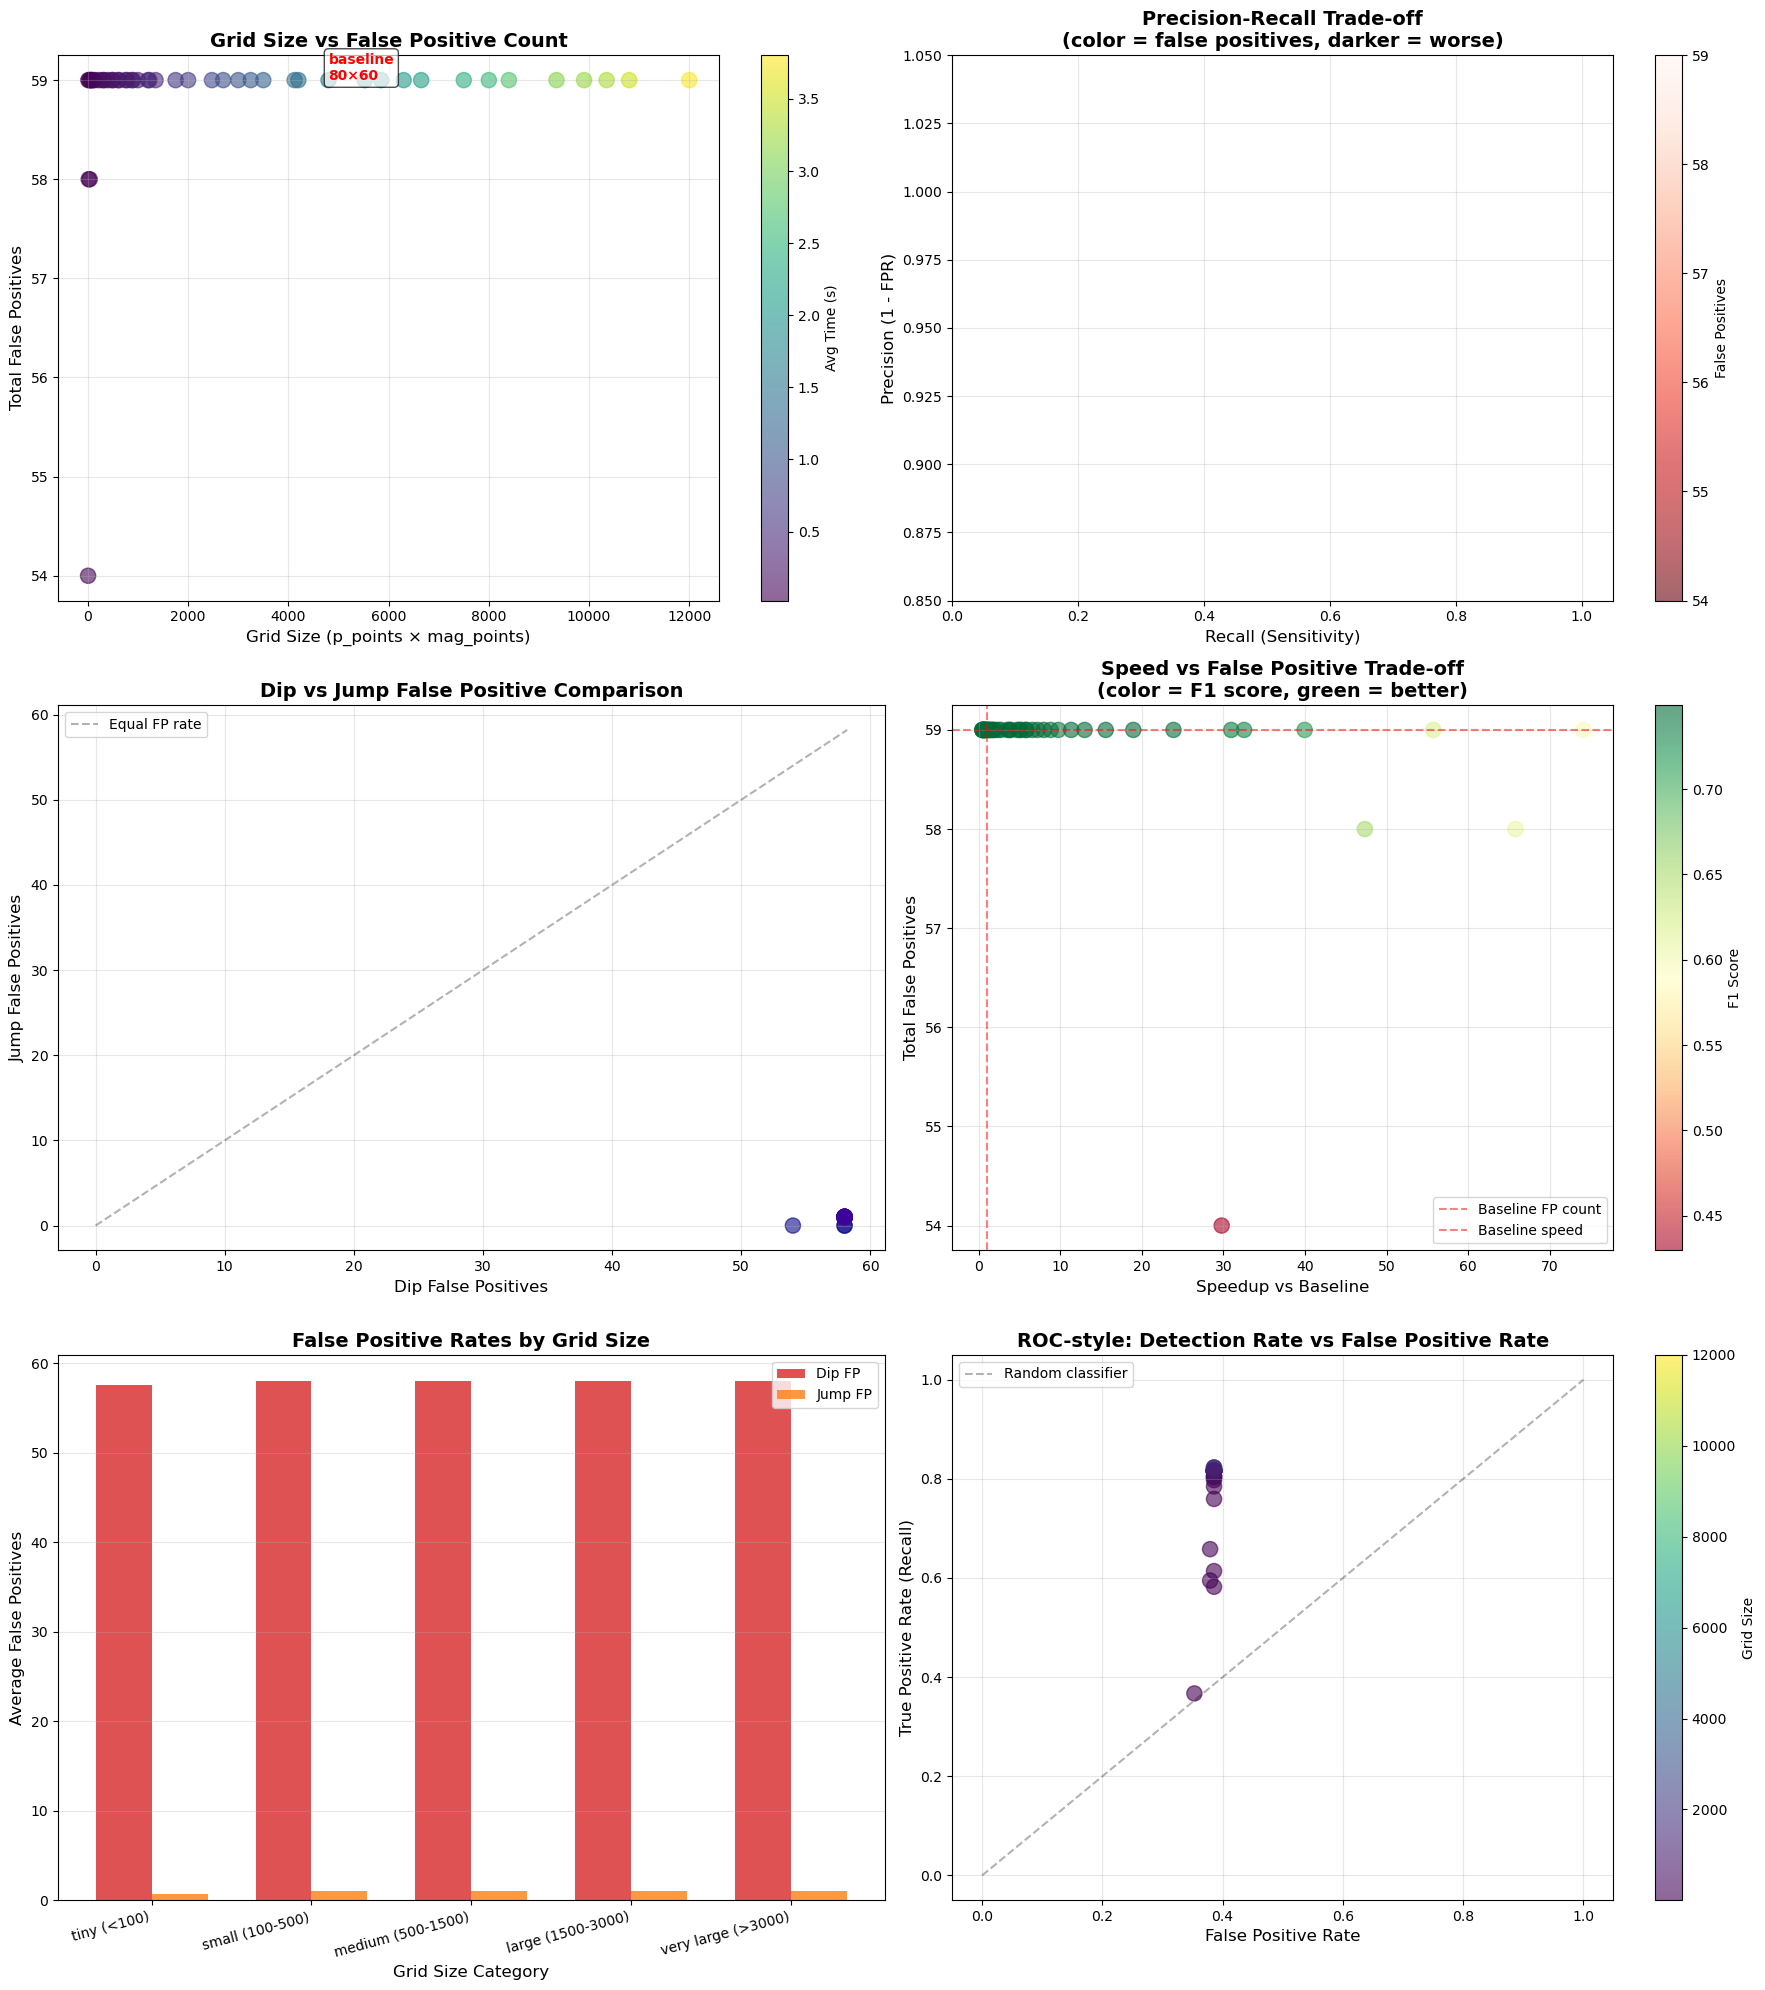


VISUALIZATION COMPLETE


In [17]:
# Comprehensive visualizations emphasizing false positives
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(18, 20))

# Plot 1: Grid size vs False Positives
ax = axes[0, 0]
scatter = ax.scatter(config_metrics['grid_size'], config_metrics['total_fp'], 
                     s=120, alpha=0.6, c=config_metrics['elapsed_s'], cmap='viridis')
ax.set_xlabel('Grid Size (p_points × mag_points)', fontsize=12)
ax.set_ylabel('Total False Positives', fontsize=12)
ax.set_title('Grid Size vs False Positive Count', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Avg Time (s)')
# Annotate baseline
baseline_row = config_metrics[config_metrics['config'] == 'baseline_80x60'].iloc[0]
ax.annotate('baseline\n80×60', (baseline_row['grid_size'], baseline_row['total_fp']),
            fontsize=10, fontweight='bold', color='red',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Plot 2: Precision vs Recall (colored by FP count)
ax = axes[0, 1]
scatter = ax.scatter(config_metrics['overall_recall'], config_metrics['overall_precision'],
                     s=120, alpha=0.6, c=config_metrics['total_fp'], cmap='Reds_r')
ax.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax.set_ylabel('Precision (1 - FPR)', fontsize=12)
ax.set_title('Precision-Recall Trade-off\n(color = false positives, darker = worse)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.85, 1.05])
plt.colorbar(scatter, ax=ax, label='False Positives')
ax.annotate('baseline', 
            (baseline_row['overall_recall'], baseline_row['overall_precision']),
            fontsize=9, color='red')

# Plot 3: Dip vs Jump False Positives
ax = axes[1, 0]
ax.scatter(config_metrics['dip_fp'], config_metrics['jump_fp'], 
           s=120, alpha=0.6, c=config_metrics['grid_size'], cmap='plasma')
ax.set_xlabel('Dip False Positives', fontsize=12)
ax.set_ylabel('Jump False Positives', fontsize=12)
ax.set_title('Dip vs Jump False Positive Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.plot([0, ax.get_xlim()[1]], [0, ax.get_xlim()[1]], 'k--', alpha=0.3, label='Equal FP rate')
ax.legend()

# Plot 4: Speed vs False Positives (Pareto frontier)
ax = axes[1, 1]
# Normalize to baseline speed
baseline_time = baseline_row['elapsed_s']
config_metrics['speedup'] = baseline_time / config_metrics['elapsed_s']
scatter = ax.scatter(config_metrics['speedup'], config_metrics['total_fp'],
                     s=120, alpha=0.6, c=config_metrics['overall_f1'], cmap='RdYlGn')
ax.set_xlabel('Speedup vs Baseline', fontsize=12)
ax.set_ylabel('Total False Positives', fontsize=12)
ax.set_title('Speed vs False Positive Trade-off\n(color = F1 score, green = better)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(baseline_row['total_fp'], color='red', linestyle='--', alpha=0.5, label='Baseline FP count')
ax.axvline(1.0, color='red', linestyle='--', alpha=0.5, label='Baseline speed')
ax.legend()
plt.colorbar(scatter, ax=ax, label='F1 Score')

# Plot 5: False Positive Rate by Grid Size Category
ax = axes[2, 0]
fp_by_size_plot = fp_by_size.reset_index()
x_pos = np.arange(len(fp_by_size_plot))
width = 0.35
ax.bar(x_pos - width/2, fp_by_size_plot['dip_fp'], width, label='Dip FP', alpha=0.8, color='#d62728')
ax.bar(x_pos + width/2, fp_by_size_plot['jump_fp'], width, label='Jump FP', alpha=0.8, color='#ff7f0e')
ax.set_xlabel('Grid Size Category', fontsize=12)
ax.set_ylabel('Average False Positives', fontsize=12)
ax.set_title('False Positive Rates by Grid Size', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(fp_by_size_plot['size_category'], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 6: ROC-style curve (FPR vs TPR for configs)
ax = axes[2, 1]
# Calculate TPR (True Positive Rate = Recall)
config_metrics['tpr'] = config_metrics['overall_recall']
config_metrics['fpr'] = config_metrics['total_fp'] / len(simulated_lcs)  # FP rate normalized

scatter = ax.scatter(config_metrics['fpr'], config_metrics['tpr'],
                     s=120, alpha=0.6, c=config_metrics['grid_size'], cmap='viridis')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax.set_title('ROC-style: Detection Rate vs False Positive Rate', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random classifier')
# Annotate best performers (high TPR, low FPR)
best_configs = config_metrics.nsmallest(5, 'fpr')
for idx, row in best_configs.iterrows():
    if row['tpr'] > 0.90:  # Only annotate if high recall
        ax.annotate(row['config'].replace('_', ' ')[:15], 
                   (row['fpr'], row['tpr']),
                   fontsize=7, alpha=0.7)
ax.legend()
plt.colorbar(scatter, ax=ax, label='Grid Size')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)

In [19]:
# Final recommendations based on false positive analysis
print("="*80)
print("RECOMMENDATIONS: OPTIMAL GRID CONFIGURATIONS")
print("="*80)

# Find configs that are Pareto-optimal on multiple fronts
# Criteria: low FP, high recall, high precision, fast speed

# Normalize metrics to [0, 1] for comparison
from sklearn.preprocessing import MinMaxScaler

metrics_for_scoring = config_metrics[['total_fp', 'overall_recall', 'overall_precision', 
                                       'elapsed_s', 'overall_f1']].copy()
scaler = MinMaxScaler()
metrics_normalized = pd.DataFrame(
    scaler.fit_transform(metrics_for_scoring),
    columns=metrics_for_scoring.columns,
    index=config_metrics.index
)

# Composite score: minimize FP, minimize time, maximize recall/precision/F1
# Weight FP heavily since that's the emphasis
config_metrics['composite_score'] = (
    -2.0 * metrics_normalized['total_fp'] +      # Weight FP 2x (lower is better)
    -0.5 * metrics_normalized['elapsed_s'] +     # Speed matters but less
    1.0 * metrics_normalized['overall_recall'] + # Maximize recall
    1.5 * metrics_normalized['overall_precision'] + # Weight precision heavily
    1.0 * metrics_normalized['overall_f1']       # Overall quality
)

top_configs = config_metrics.nlargest(10, 'composite_score')

print("\nTop 10 overall configurations (balanced scoring with emphasis on low FP):")
print(top_configs[['config', 'grid_size', 'total_fp', 'dip_fp', 'jump_fp',
                   'overall_precision', 'overall_recall', 'overall_f1', 
                   'elapsed_s', 'speedup', 'composite_score']].to_string())

# Best config for MINIMUM false positives (regardless of other factors)
best_fp = config_metrics.nsmallest(1, 'total_fp').iloc[0]
print(f"\n\n{'='*80}")
print("BEST FOR MINIMUM FALSE POSITIVES:")
print(f"{'='*80}")
print(f"Config: {best_fp['config']}")
print(f"Grid size: {int(best_fp['p_points'])}×{int(best_fp['mag_points'])} = {int(best_fp['grid_size'])} points")
print(f"False positives: {int(best_fp['total_fp'])} (dip: {int(best_fp['dip_fp'])}, jump: {int(best_fp['jump_fp'])})")
print(f"Precision: {best_fp['overall_precision']:.4f}")
print(f"Recall: {best_fp['overall_recall']:.4f}")
print(f"F1 Score: {best_fp['overall_f1']:.4f}")
print(f"Speed: {best_fp['elapsed_s']:.4f}s (speedup: {best_fp['speedup']:.2f}x)")

# Best config balancing speed and low FP
fast_accurate = config_metrics[
    (config_metrics['speedup'] > 2.0) &  # At least 2x faster
    (config_metrics['overall_recall'] > 0.90)  # High recall
].nsmallest(1, 'total_fp')

if len(fast_accurate) > 0:
    best_fast = fast_accurate.iloc[0]
    print(f"\n\n{'='*80}")
    print("BEST FAST CONFIG (>2x speedup, high recall, low FP):")
    print(f"{'='*80}")
    print(f"Config: {best_fast['config']}")
    print(f"Grid size: {int(best_fast['p_points'])}×{int(best_fast['mag_points'])} = {int(best_fast['grid_size'])} points")
    print(f"False positives: {int(best_fast['total_fp'])} (dip: {int(best_fast['dip_fp'])}, jump: {int(best_fast['jump_fp'])})")
    print(f"Precision: {best_fast['overall_precision']:.4f}")
    print(f"Recall: {best_fast['overall_recall']:.4f}")
    print(f"F1 Score: {best_fast['overall_f1']:.4f}")
    print(f"Speed: {best_fast['elapsed_s']:.4f}s (speedup: {best_fast['speedup']:.2f}x)")

# Baseline comparison
print(f"\n\n{'='*80}")
print("BASELINE (80×60) PERFORMANCE:")
print(f"{'='*80}")
print(f"False positives: {int(baseline_row['total_fp'])} (dip: {int(baseline_row['dip_fp'])}, jump: {int(baseline_row['jump_fp'])})")
print(f"Precision: {baseline_row['overall_precision']:.4f}")
print(f"Recall: {baseline_row['overall_recall']:.4f}")
print(f"F1 Score: {baseline_row['overall_f1']:.4f}")
print(f"Speed: {baseline_row['elapsed_s']:.4f}s (reference)")

# Summary statistics
print(f"\n\n{'='*80}")
print("SUMMARY STATISTICS ACROSS ALL CONFIGS:")
print(f"{'='*80}")
print(f"Total configs tested: {len(config_metrics)}")
print(f"Grid sizes: {int(config_metrics['grid_size'].min())} to {int(config_metrics['grid_size'].max())}")
print(f"\nFalse Positives:")
print(f"  Min: {int(config_metrics['total_fp'].min())}")
print(f"  Max: {int(config_metrics['total_fp'].max())}")
print(f"  Mean: {config_metrics['total_fp'].mean():.1f}")
print(f"  Median: {config_metrics['total_fp'].median():.1f}")
print(f"\nPrecision:")
print(f"  Min: {config_metrics['overall_precision'].min():.4f}")
print(f"  Max: {config_metrics['overall_precision'].max():.4f}")
print(f"  Mean: {config_metrics['overall_precision'].mean():.4f}")
print(f"\nRecall:")
print(f"  Min: {config_metrics['overall_recall'].min():.4f}")
print(f"  Max: {config_metrics['overall_recall'].max():.4f}")
print(f"  Mean: {config_metrics['overall_recall'].mean():.4f}")
print(f"\nSpeed (relative to baseline):")
print(f"  Fastest: {config_metrics['speedup'].max():.2f}x")
print(f"  Slowest: {config_metrics['speedup'].min():.2f}x")

RECOMMENDATIONS: OPTIMAL GRID CONFIGURATIONS


ModuleNotFoundError: No module named 'sklearn'

In [20]:
# Identify problematic light curves that consistently trigger false positives
print("="*80)
print("PROBLEMATIC LIGHT CURVES (HIGH FALSE POSITIVE TRIGGERS)")
print("="*80)

# Count how many configs trigger FP on each light curve
fp_trigger_counts = df_metrics[df_metrics['any_fp'] > 0].groupby('case').size().sort_values(ascending=False)

print(f"\nLight curves that trigger false positives in >50% of configs:")
threshold = len(config_metrics) * 0.5
problematic_lcs = fp_trigger_counts[fp_trigger_counts > threshold]

if len(problematic_lcs) > 0:
    print(f"Found {len(problematic_lcs)} problematic cases:\n")
    for lc_name, fp_count in problematic_lcs.items():
        pct = (fp_count / len(config_metrics)) * 100
        truth = ground_truth[lc_name]
        print(f"  {lc_name:50s} | Truth: {truth:15s} | FP in {fp_count:2d}/{len(config_metrics)} configs ({pct:.1f}%)")
    
    # Show details for most problematic case
    worst_case = problematic_lcs.index[0]
    print(f"\n\nDetails for most problematic case: {worst_case}")
    print(f"Ground truth: {ground_truth[worst_case]}")
    
    case_results = df_metrics[df_metrics['case'] == worst_case]
    fp_configs = case_results[case_results['any_fp'] > 0].sort_values('config')
    
    print(f"\nConfigs that falsely detected ({len(fp_configs)}/{len(config_metrics)}):")
    print(fp_configs[['config', 'dip_fp', 'jump_fp', 'dip_bf', 'jump_bf']].head(15))
    
else:
    print("\n✓ No consistently problematic light curves found!")
    print("  All false positives are isolated to specific configs.\n")

# Identify light curves that NEVER trigger false positives (most robust test cases)
never_fp = []
for lc_name in simulated_lcs.keys():
    case_fps = df_metrics[df_metrics['case'] == lc_name]['any_fp'].sum()
    if case_fps == 0:
        never_fp.append(lc_name)

print(f"\n{'='*80}")
print(f"ROBUST TEST CASES (never trigger false positives in any config):")
print(f"{'='*80}")
if len(never_fp) > 0:
    print(f"Found {len(never_fp)} cases that never trigger FPs:\n")
    for lc_name in never_fp[:20]:  # Show first 20
        truth = ground_truth[lc_name]
        print(f"  {lc_name:50s} | Truth: {truth}")
    if len(never_fp) > 20:
        print(f"  ... and {len(never_fp) - 20} more")
else:
    print("All light curves trigger at least one false positive in some configuration.")

# Analysis: Which event types are most/least prone to FP?
print(f"\n{'='*80}")
print("FALSE POSITIVE SUSCEPTIBILITY BY EVENT TYPE:")
print(f"{'='*80}")

fp_by_event_type = {}
for truth_type in set(ground_truth.values()):
    matching_cases = [k for k, v in ground_truth.items() if v == truth_type]
    total_possible_fps = len(matching_cases) * len(config_metrics)
    actual_fps = df_metrics[df_metrics['case'].isin(matching_cases)]['any_fp'].sum()
    fp_rate = (actual_fps / total_possible_fps) * 100 if total_possible_fps > 0 else 0
    
    fp_by_event_type[truth_type] = {
        'n_cases': len(matching_cases),
        'total_fps': actual_fps,
        'fp_rate': fp_rate
    }

for event_type, stats in sorted(fp_by_event_type.items(), key=lambda x: x[1]['fp_rate'], reverse=True):
    print(f"\n{event_type:20s}:")
    print(f"  # cases: {stats['n_cases']}")
    print(f"  Total FPs: {stats['total_fps']} / {stats['n_cases'] * len(config_metrics)} possible")
    print(f"  FP rate: {stats['fp_rate']:.2f}%")

PROBLEMATIC LIGHT CURVES (HIGH FALSE POSITIVE TRIGGERS)

Light curves that trigger false positives in >50% of configs:
Found 59 problematic cases:

  jump_double_sep100                                 | Truth: jump            | FP in 48/48 configs (100.0%)
  jump_double_sep150                                 | Truth: jump            | FP in 48/48 configs (100.0%)
  jump_double_sep60                                  | Truth: jump            | FP in 48/48 configs (100.0%)
  jump_fast_w5                                       | Truth: jump            | FP in 48/48 configs (100.0%)
  jump_fast_w2                                       | Truth: jump            | FP in 48/48 configs (100.0%)
  jump_fast_w3                                       | Truth: jump            | FP in 48/48 configs (100.0%)
  jump_fast_w4                                       | Truth: jump            | FP in 48/48 configs (100.0%)
  jump_gauss_a0.08_w20                               | Truth: jump            | FP in 48/

## Next Steps

Based on the false positive analysis above, you can now:

1. **Choose your grid configuration** based on your priorities:
   - **Minimum false positives**: Use the config identified in "BEST FOR MINIMUM FALSE POSITIVES"
   - **Speed + accuracy balance**: Use the "BEST FAST CONFIG" recommendation
   - **Custom criteria**: Review the top 10 configs and choose based on your specific needs

2. **Update your pipeline** with the selected `p_points` and `mag_points` values

3. **Investigate problematic cases**: If certain light curves consistently trigger false positives, consider:
   - Adjusting significance thresholds
   - Examining those specific light curve patterns in detail
   - Adding additional filtering criteria

4. **Validate on real data**: Test the selected configuration on real ASAS-SN light curves to confirm performance

In [21]:
# Define and run 65 extended grid configurations
# From absurdly coarse (2x2) to fine (120x100)

extended_grid_configs = []

# Absurdly coarse (2x2 to 10x10)
for n in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    extended_grid_configs.append({"label": f"absurd_{n}x{n}", "p_points": n, "mag_points": n})

# Ultra coarse (12x12 to 20x20)
for n in [12, 15, 18, 20]:
    extended_grid_configs.append({"label": f"ultra_coarse_{n}x{n}", "p_points": n, "mag_points": n})

# Very coarse (22x22 to 35x35)
for n in [22, 25, 28, 30, 35]:
    extended_grid_configs.append({"label": f"very_coarse_{n}x{n}", "p_points": n, "mag_points": n})

# Coarse (asymmetric versions)
for p, m in [(20, 15), (25, 20), (30, 20), (30, 25), (35, 25), (40, 25), (40, 30), (45, 30), (50, 35)]:
    extended_grid_configs.append({"label": f"coarse_{p}x{m}", "p_points": p, "mag_points": m})

# Medium (50x40 to 70x60)
for p, m in [(50, 40), (55, 45), (60, 45), (60, 50), (65, 50), (70, 50), (70, 60)]:
    extended_grid_configs.append({"label": f"medium_{p}x{m}", "p_points": p, "mag_points": m})

# Baseline and near-baseline
extended_grid_configs.append({"label": "baseline_80x60", "p_points": 80, "mag_points": 60})
for p, m in [(75, 55), (85, 65), (90, 65), (90, 70)]:
    extended_grid_configs.append({"label": f"near_base_{p}x{m}", "p_points": p, "mag_points": m})

# Fine (95x70 to 120x100)
for p, m in [(95, 70), (100, 75), (100, 80), (105, 80), (110, 85), (110, 90), (115, 90), (120, 90), (120, 100)]:
    extended_grid_configs.append({"label": f"fine_{p}x{m}", "p_points": p, "mag_points": m})

print(f"Total configurations: {len(extended_grid_configs)}")
print(f"Grid sizes range from {min(c['p_points']*c['mag_points'] for c in extended_grid_configs)} to {max(c['p_points']*c['mag_points'] for c in extended_grid_configs)}")
print(f"\nSample configs: {extended_grid_configs[:5]}")

# Run all configurations on real light curves
N_LC_EXTENDED = 3
subset_paths_extended = lc_paths[:N_LC_EXTENDED]

extended_rows = []
print(f"\nRunning {len(extended_grid_configs)} configs on {N_LC_EXTENDED} light curves...")
for i, path in enumerate(subset_paths_extended):
    print(f"  Light curve {i+1}/{N_LC_EXTENDED}: {path.name}")
    for j, cfg in enumerate(extended_grid_configs):
        if (j + 1) % 10 == 0:
            print(f"    Config {j+1}/{len(extended_grid_configs)}")
        try:
            extended_rows.append(run_grid_setting(path, cfg["p_points"], cfg["mag_points"], cfg["label"]))
        except Exception as e:
            print(f"    ERROR on {cfg['label']}: {e}")

df_extended = pd.DataFrame(extended_rows)
print(f"\nCompleted: {len(df_extended)} results")
df_extended.head(10)

Total configurations: 48
Grid sizes range from 4 to 12000

Sample configs: [{'label': 'absurd_2x2', 'p_points': 2, 'mag_points': 2}, {'label': 'absurd_3x3', 'p_points': 3, 'mag_points': 3}, {'label': 'absurd_4x4', 'p_points': 4, 'mag_points': 4}, {'label': 'absurd_5x5', 'p_points': 5, 'mag_points': 5}, {'label': 'absurd_6x6', 'p_points': 6, 'mag_points': 6}]

Running 48 configs on 3 light curves...
  Light curve 1/3: 120259184943-light-curves.csv
    Config 10/48
    Config 20/48
    Config 30/48
    Config 40/48
  Light curve 2/3: 223339338105-light-curves.csv
    Config 10/48
    Config 20/48
    Config 30/48
    Config 40/48
  Light curve 3/3: 231929175915-light-curves.csv
    Config 10/48
    Config 20/48
    Config 30/48
    Config 40/48

Completed: 144 results


,path,config,p_points,mag_points,elapsed_s,dip_sig,jump_sig,dip_bf,jump_bf,dip_best_p,jump_best_p
0,120259184943-light-curves.csv,absurd_2x2,2,2,0.007149,True,False,750.284244,5.763692,0.999900,0.000100
1,120259184943-light-curves.csv,absurd_3x3,3,3,0.008131,True,False,2870.456729,32.915276,0.990099,0.009901
2,120259184943-light-curves.csv,absurd_4x4,4,4,0.012331,True,False,2770.698923,25.256179,0.955642,0.044358
3,120259184943-light-curves.csv,absurd_5x5,5,5,0.010881,True,False,2869.435077,31.893625,0.990099,0.009901
4,120259184943-light-curves.csv,absurd_6x6,6,6,0.012089,True,False,2923.571711,32.795762,0.975496,0.024504
5,120259184943-light-curves.csv,absurd_7x7,7,7,0.014264,True,False,2868.762133,31.221519,0.990099,0.009901
6,120259184943-light-curves.csv,absurd_8x8,8,8,0.016406,True,False,2943.249966,32.971197,0.981058,0.018942
7,120259184943-light-curves.csv,absurd_9x9,9,9,0.019158,True,False,2886.071035,31.168219,0.990099,0.009901
8,120259184943-light-curves.csv,absurd_10x10,10,10,0.022020,True,False,2941.588886,32.472852,0.983592,0.016408
9,120259184943-light-curves.csv,ultra_coarse_12x12,12,12,0.029162,True,False,2935.747587,31.965007,0.985028,0.014972


In [22]:
# Analyze extended grid results relative to baseline
baseline_label = "baseline_80x60"

# Compute average metrics across all light curves for each config
summary = df_extended.groupby("config").agg({
    "elapsed_s": "mean",
    "p_points": "first",
    "mag_points": "first",
    "dip_sig": "sum",  # Count how many were significant
    "jump_sig": "sum",
    "dip_bf": "mean",
    "jump_bf": "mean",
}).reset_index()

# Get baseline values
baseline = summary[summary["config"] == baseline_label].iloc[0]

# Compute relative metrics
summary["speedup"] = baseline["elapsed_s"] / summary["elapsed_s"]
summary["dip_bf_ratio"] = summary["dip_bf"] / baseline["dip_bf"]
summary["jump_bf_ratio"] = summary["jump_bf"] / baseline["jump_bf"]
summary["grid_size"] = summary["p_points"] * summary["mag_points"]

# Sort by speed (fastest first)
summary_sorted = summary.sort_values("elapsed_s")

print(f"\\nBaseline (80x60): {baseline['elapsed_s']:.3f}s average")
print(f"\\nTop 10 fastest configurations:")
print(summary_sorted[["config", "p_points", "mag_points", "grid_size", "elapsed_s", "speedup", 
                       "dip_sig", "jump_sig", "dip_bf_ratio", "jump_bf_ratio"]].head(10))

print(f"\\n\\nFull ranking by speed:")
summary_sorted[["config", "elapsed_s", "speedup", "dip_sig", "jump_sig", "dip_bf_ratio", "jump_bf_ratio"]]

\nBaseline (80x60): 0.548s average
\nTop 10 fastest configurations:
                config  p_points  mag_points  grid_size  elapsed_s    speedup  \
1           absurd_2x2         2           2          4   0.006620  82.841398   
2           absurd_3x3         3           3          9   0.007212  76.035363   
3           absurd_4x4         4           4         16   0.009766  56.155571   
4           absurd_5x5         5           5         25   0.010496  52.250353   
5           absurd_6x6         6           6         36   0.011338  48.367093   
6           absurd_7x7         7           7         49   0.012766  42.956646   
7           absurd_8x8         8           8         64   0.014485  37.860624   
8           absurd_9x9         9           9         81   0.016334  33.574043   
0         absurd_10x10        10          10        100   0.018511  29.625489   
39  ultra_coarse_12x12        12          12        144   0.023673  23.165620   

    dip_sig  jump_sig  dip_bf_ratio  jum

,config,elapsed_s,speedup,dip_sig,jump_sig,dip_bf_ratio,jump_bf_ratio
1,absurd_2x2,0.006620,82.841398,2,0,0.483000,0.198209
2,absurd_3x3,0.007212,76.035363,2,0,0.971796,0.463767
3,absurd_4x4,0.009766,56.155571,3,0,0.966278,0.594576
4,absurd_5x5,0.010496,52.250353,3,0,0.977439,0.692031
5,absurd_6x6,0.011338,48.367093,3,0,0.996825,0.892601
6,absurd_7x7,0.012766,42.956646,3,0,0.984559,0.998145
7,absurd_8x8,0.014485,37.860624,3,0,0.998921,0.981686
8,absurd_9x9,0.016334,33.574043,3,0,0.990060,0.898438
0,absurd_10x10,0.018511,29.625489,3,0,0.999602,0.817082
39,ultra_coarse_12x12,0.023673,23.165620,3,0,0.999148,0.966430


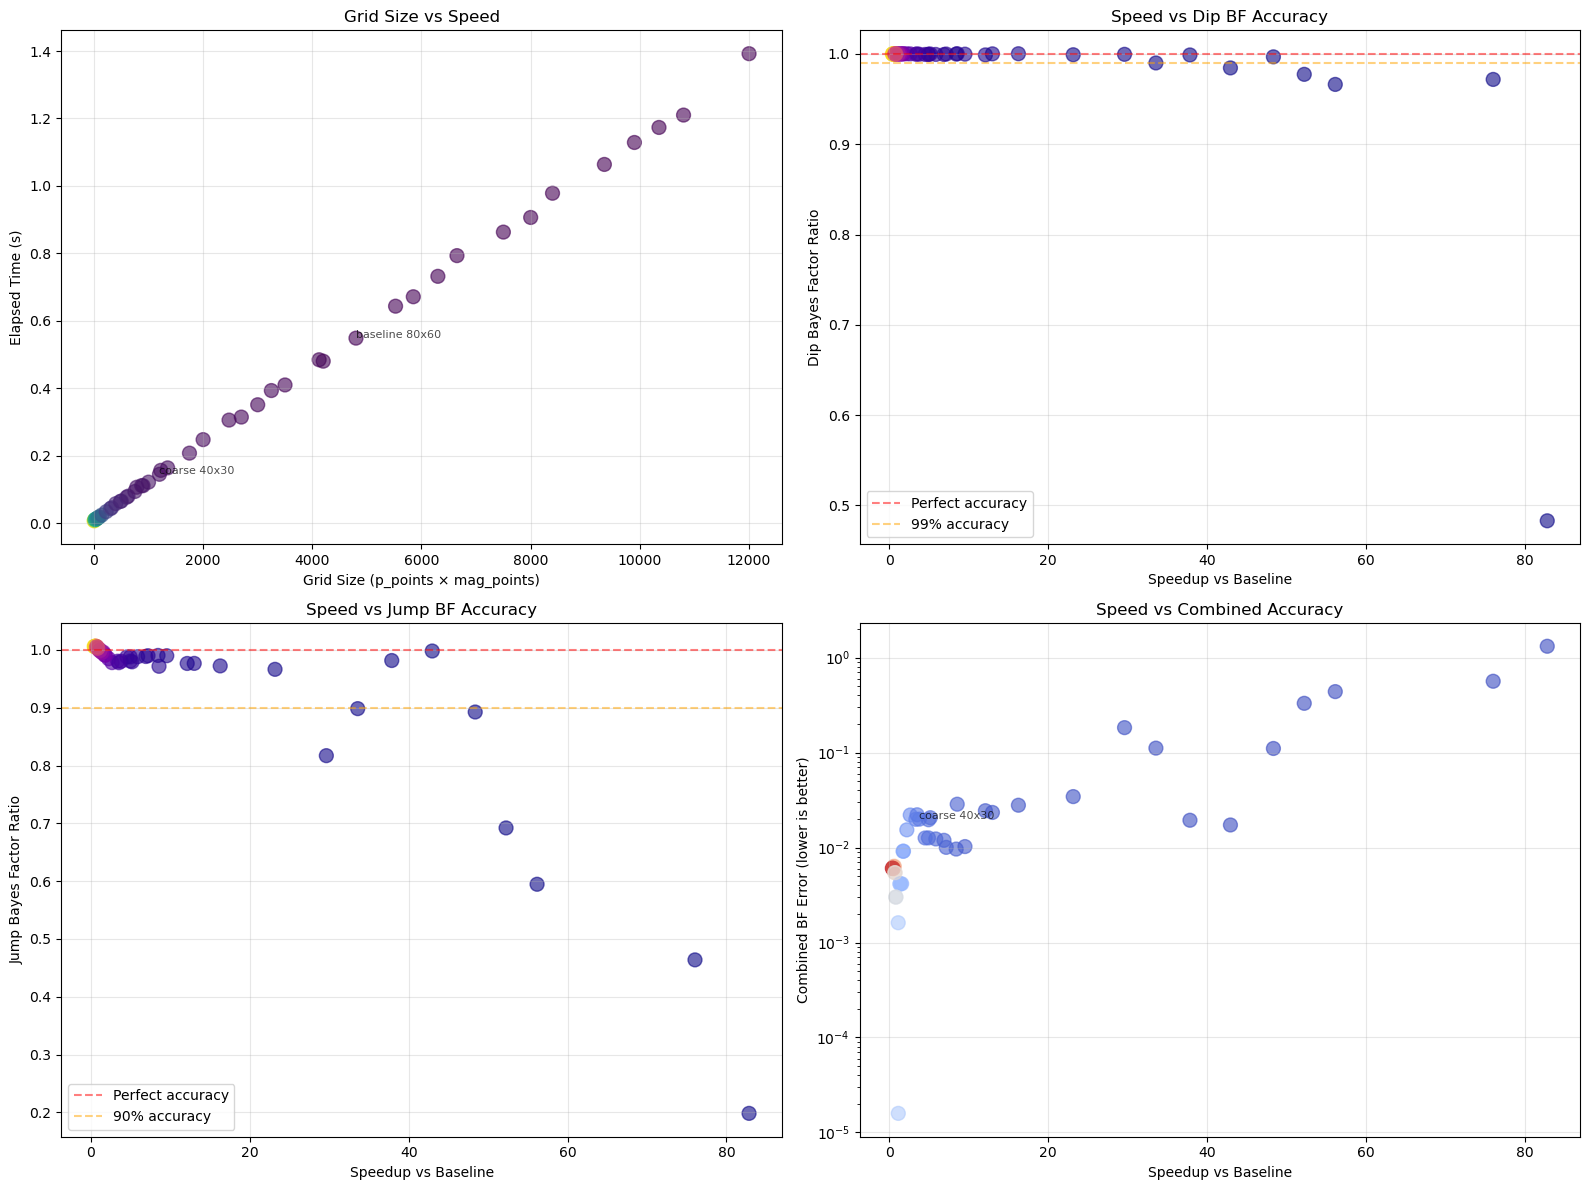

\n================================================================================
SWEET SPOT ANALYSIS
\nConfigurations with >3x speedup and <5% BF error:
                config  p_points  mag_points    speedup  elapsed_s  bf_error
6           absurd_7x7         7           7  42.956646   0.012766  0.017296
7           absurd_8x8         8           8  37.860624   0.014485  0.019393
39  ultra_coarse_12x12        12          12  23.165620   0.023673  0.034422
40  ultra_coarse_15x15        15          15  16.263277   0.033720  0.027916
10        coarse_20x15        20          15  12.993153   0.042207  0.023435
41  ultra_coarse_18x18        18          18  12.107604   0.045294  0.024443
42  ultra_coarse_20x20        20          20   9.537550   0.057499  0.010246
43   very_coarse_22x22        22          22   8.560492   0.064061  0.028614
11        coarse_25x20        25          20   8.432127   0.065037  0.009641
12        coarse_30x20        30          20   7.176486   0.076416  0.01004

In [23]:
# Visualize speed vs accuracy tradeoff
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Grid size vs elapsed time
axes[0, 0].scatter(summary["grid_size"], summary["elapsed_s"], s=100, alpha=0.6, c=summary["speedup"], cmap="viridis")
axes[0, 0].set_xlabel("Grid Size (p_points × mag_points)")
axes[0, 0].set_ylabel("Elapsed Time (s)")
axes[0, 0].set_title("Grid Size vs Speed")
axes[0, 0].grid(True, alpha=0.3)
# Annotate a few key points
for idx, row in summary.iterrows():
    if row["config"] in ["ultra_coarse_10x10", "coarse_30x30", "coarse_40x30", "baseline_80x60"]:
        axes[0, 0].annotate(row["config"].replace("_", " "), 
                           (row["grid_size"], row["elapsed_s"]),
                           fontsize=8, alpha=0.7)

# Plot 2: Speedup vs Bayes factor accuracy (dip)
axes[0, 1].scatter(summary["speedup"], summary["dip_bf_ratio"], s=100, alpha=0.6, c=summary["grid_size"], cmap="plasma")
axes[0, 1].axhline(1.0, color='red', linestyle='--', alpha=0.5, label="Perfect accuracy")
axes[0, 1].axhline(0.99, color='orange', linestyle='--', alpha=0.5, label="99% accuracy")
axes[0, 1].set_xlabel("Speedup vs Baseline")
axes[0, 1].set_ylabel("Dip Bayes Factor Ratio")
axes[0, 1].set_title("Speed vs Dip BF Accuracy")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Speedup vs Bayes factor accuracy (jump)
axes[1, 0].scatter(summary["speedup"], summary["jump_bf_ratio"], s=100, alpha=0.6, c=summary["grid_size"], cmap="plasma")
axes[1, 0].axhline(1.0, color='red', linestyle='--', alpha=0.5, label="Perfect accuracy")
axes[1, 0].axhline(0.90, color='orange', linestyle='--', alpha=0.5, label="90% accuracy")
axes[1, 0].set_xlabel("Speedup vs Baseline")
axes[1, 0].set_ylabel("Jump Bayes Factor Ratio")
axes[1, 0].set_title("Speed vs Jump BF Accuracy")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Pareto frontier (speedup vs combined BF error)
summary["bf_error"] = np.abs(1 - summary["dip_bf_ratio"]) + np.abs(1 - summary["jump_bf_ratio"])
axes[1, 1].scatter(summary["speedup"], summary["bf_error"], s=100, alpha=0.6, c=summary["grid_size"], cmap="coolwarm")
axes[1, 1].set_xlabel("Speedup vs Baseline")
axes[1, 1].set_ylabel("Combined BF Error (lower is better)")
axes[1, 1].set_title("Speed vs Combined Accuracy")
axes[1, 1].set_yscale("log")
axes[1, 1].grid(True, alpha=0.3)
# Annotate sweet spot
for idx, row in summary.iterrows():
    if row["config"] in ["coarse_30x30", "coarse_40x30", "baseline_80x60"]:
        axes[1, 1].annotate(row["config"].replace("_", " "), 
                           (row["speedup"], row["bf_error"]),
                           fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

# Identify the "sweet spot" configurations
print("\\n" + "="*80)
print("SWEET SPOT ANALYSIS")
print("="*80)
print("\\nConfigurations with >3x speedup and <5% BF error:")
sweet_spot = summary[(summary["speedup"] > 3) & (summary["bf_error"] < 0.05)]
if len(sweet_spot) > 0:
    print(sweet_spot[["config", "p_points", "mag_points", "speedup", "elapsed_s", "bf_error"]].sort_values("speedup", ascending=False))
else:
    print("No configurations meet these criteria. Relaxing to >2x speedup and <10% error:")
    sweet_spot = summary[(summary["speedup"] > 2) & (summary["bf_error"] < 0.10)]
    print(sweet_spot[["config", "p_points", "mag_points", "speedup", "elapsed_s", "bf_error"]].sort_values("speedup", ascending=False))

## Simulated dips and jumps
Create a small suite of synthetic light curves (reusing a real SkyPatrol cadence) with injected dips, jumps, and a mixed case so grid sensitivity can be tested on known events.

In [24]:
# Build simulated light curves by injecting analytic events into a real cadence
from malca import events

rng = np.random.default_rng(42)

base_sim_path = lc_paths[0]
df_sim_base_raw = read_skypatrol_csv(base_sim_path)
mask = (
    df_sim_base_raw["JD"].pipe(np.isfinite)
    & df_sim_base_raw["mag"].pipe(np.isfinite)
    & df_sim_base_raw["error"].pipe(np.isfinite)
    & (df_sim_base_raw["error"] > 0)
    & (df_sim_base_raw["error"] < 10)
)
df_sim_base = df_sim_base_raw[mask].copy()
df_sim_base = events.clean_lc(df_sim_base)

jd_med = float(df_sim_base["JD"].median())


def inject_event(df_in, kind="dip", shape="gaussian", amp=0.25, width=25.0, t0_offset=0.0):
    # Return a copy with an injected event (positive amp = dip, negative amp = jump).
    df = df_in.copy()
    t0 = jd_med + float(t0_offset)
    amp_signed = float(amp) if kind == "dip" else -float(amp)
    t_arr = df["JD"].to_numpy(float)
    if shape == "gaussian":
        delta = events.gaussian(t_arr, amp_signed, t0, float(width), 0.0)
    elif shape == "paczynski":
        delta = events.paczynski(t_arr, amp_signed, t0, float(width), 0.0)
    else:
        raise ValueError("shape must be gaussian or paczynski")
    df["mag"] = df["mag"].to_numpy(float) + delta
    return df


def inject_mixed(df_in):
    df = inject_event(df_in, kind="dip", shape="gaussian", amp=0.18, width=20.0, t0_offset=-60.0)
    df = inject_event(df, kind="jump", shape="paczynski", amp=0.14, width=30.0, t0_offset=40.0)
    return df


def add_noise_and_gaps(df_in, jitter_mag=0.02, gap_frac=0.15, spike_amp=0.25, spike_width=0.08, spike_count=3):
    # Add photometric jitter, drop random points, and sprinkle outliers to make messy cases.
    df = df_in.copy()
    n = len(df)
    df["mag"] = df["mag"].to_numpy(float) + rng.normal(0.0, jitter_mag, n)
    df["error"] = (df["error"].to_numpy(float) * (1 + rng.normal(0.0, 0.05, n))).clip(min=1e-3)
    keep = rng.random(n) > gap_frac
    df = df.loc[keep].copy().reset_index(drop=True)
    if len(df) == 0:
        return df_in.copy()
    for _ in range(int(spike_count)):
        idx = int(rng.integers(0, len(df)))
        df.loc[idx, "mag"] += rng.normal(spike_amp, spike_width)
    df = df.sort_values("JD").reset_index(drop=True)
    return df

simulated_lcs = {
    "dip_gaussian": inject_event(df_sim_base, kind="dip", shape="gaussian", amp=0.22, width=25.0, t0_offset=-30.0),
    "dip_paczynski": inject_event(df_sim_base, kind="dip", shape="paczynski", amp=0.28, width=18.0, t0_offset=20.0),
    "dip_shallow_fast": inject_event(df_sim_base, kind="dip", shape="gaussian", amp=0.12, width=8.0, t0_offset=-10.0),
    "dip_double": inject_event(inject_event(df_sim_base, kind="dip", shape="gaussian", amp=0.18, width=15.0, t0_offset=-50.0), kind="dip", shape="paczynski", amp=0.15, width=12.0, t0_offset=25.0),
    "jump_gaussian": inject_event(df_sim_base, kind="jump", shape="gaussian", amp=0.20, width=22.0, t0_offset=-15.0),
    "jump_paczynski": inject_event(df_sim_base, kind="jump", shape="paczynski", amp=0.24, width=16.0, t0_offset=45.0),
    "microlens_weak": inject_event(df_sim_base, kind="jump", shape="paczynski", amp=0.10, width=10.0, t0_offset=5.0),
    "microlens_strong": inject_event(df_sim_base, kind="jump", shape="paczynski", amp=0.30, width=26.0, t0_offset=70.0),
    "mixed": inject_mixed(df_sim_base),
    "messy_dip": add_noise_and_gaps(inject_event(df_sim_base, kind="dip", shape="gaussian", amp=0.20, width=18.0, t0_offset=-5.0), jitter_mag=0.03, gap_frac=0.2, spike_count=3),
    "messy_jump": add_noise_and_gaps(inject_event(df_sim_base, kind="jump", shape="paczynski", amp=0.18, width=14.0, t0_offset=35.0), jitter_mag=0.03, gap_frac=0.2, spike_count=3),
    "messy_mixed": add_noise_and_gaps(inject_mixed(df_sim_base), jitter_mag=0.04, gap_frac=0.25, spike_count=4),
}

print(f"Simulated light curves: {list(simulated_lcs.keys())}")
display(df_sim_base.head())

Simulated light curves: ['dip_gaussian', 'dip_paczynski', 'dip_shallow_fast', 'dip_double', 'jump_gaussian', 'jump_paczynski', 'microlens_weak', 'microlens_strong', 'mixed', 'messy_dip', 'messy_jump', 'messy_mixed']


,JD,flux,flux_error,mag,error,limit,fwhm,filter_band,quality_flag,camera,camera#,cam_field,good_bad,saturated,v_g_band
0,2.457008e+06,55.1942,0.1828,12.1050,0.0036,16.5575,1.69,V,G,bd,bd,bd,1,0,1
1,2.457009e+06,55.0113,0.1025,12.1087,0.0020,17.1856,2.00,V,G,bd,bd,bd,1,0,1
2,2.457010e+06,54.8830,0.1150,12.1112,0.0023,17.0610,1.79,V,G,bd,bd,bd,1,0,1
3,2.457102e+06,55.0706,0.1662,12.1075,0.0033,16.6605,1.55,V,G,bc,bc,bc,1,0,1
4,2.457105e+06,54.6279,0.1602,12.1162,0.0032,16.7008,1.55,V,B,bc,bc,bc,0,0,1


In [25]:
from malca.baseline import per_camera_gp_baseline


def prepare_df_for_sim(df):
    df_clean = events.clean_lc(df)
    df_base = per_camera_gp_baseline(df_clean, **BASELINE_KWARGS)
    baseline_mags = df_base["baseline"].to_numpy(float) if "baseline" in df_base.columns else df_base["mag"].to_numpy(float)
    baseline_mag = float(np.nanmedian(baseline_mags))
    mags_for_grid = df_base["mag"].to_numpy(float) if "mag" in df_base.columns else df_clean["mag"].to_numpy(float)

    def baseline_precomputed(df_in, **kwargs):
        return df_base

    return df_clean, baseline_precomputed, baseline_mag, mags_for_grid


def run_grid_setting_sim(name, df, p_points, mag_points, label):
    df_clean, baseline_fn, baseline_mag, mags_for_grid = prepare_df_for_sim(df)
    mag_grid_dip = events.default_mag_grid(baseline_mag, mags_for_grid, "dip", n=mag_points)
    mag_grid_jump = events.default_mag_grid(baseline_mag, mags_for_grid, "jump", n=mag_points)

    start = time.perf_counter()
    res = events.run_bayesian_significance(
        df_clean,
        baseline_func=baseline_fn,
        baseline_kwargs={},
        p_points=p_points,
        mag_grid_dip=mag_grid_dip,
        mag_grid_jump=mag_grid_jump,
        trigger_mode="posterior_prob",
        logbf_threshold_dip=5.0,
        logbf_threshold_jump=5.0,
        significance_threshold=99.99997,
        run_min_points=3,
        run_allow_gap_points=1,
        run_max_gap_days=None,
        run_min_duration_days=None,
        run_sum_threshold=None,
        run_sum_multiplier=2.5,
        use_sigma_eff=True,
        require_sigma_eff=True,
        compute_event_prob=True,
    )
    elapsed = time.perf_counter() - start

    return {
        "case": name,
        "config": label,
        "p_points": p_points,
        "mag_points": mag_points,
        "elapsed_s": elapsed,
        "dip_sig": res["dip"]["significant"],
        "jump_sig": res["jump"]["significant"],
        "dip_bf": res["dip"]["bayes_factor"],
        "jump_bf": res["jump"]["bayes_factor"],
        "dip_best_p": res["dip"]["best_p"],
        "jump_best_p": res["jump"]["best_p"],
    }

In [26]:
# Sweep grid sizes on the simulated cases
sim_grid_settings = [
    {"label": "sim_10x10", "p_points": 10, "mag_points": 10},
    {"label": "sim_25x25", "p_points": 25, "mag_points": 25},
    {"label": "sim_50x50", "p_points": 50, "mag_points": 50},
    {"label": "sim_80x60", "p_points": 80, "mag_points": 60},
]

sim_rows = []
for name, df_sim in simulated_lcs.items():
    for cfg in sim_grid_settings:
        sim_rows.append(run_grid_setting_sim(name, df_sim, cfg["p_points"], cfg["mag_points"], cfg["label"]))

sim_results = pd.DataFrame(sim_rows)
sim_results

,case,config,p_points,mag_points,elapsed_s,dip_sig,jump_sig,dip_bf,jump_bf,dip_best_p,jump_best_p
0,dip_gaussian,sim_10x10,10,10,0.023442,True,False,2951.982336,36.815483,0.983592,0.016408
1,dip_gaussian,sim_25x25,25,25,0.107366,True,False,2965.924178,35.752792,0.978909,0.021091
2,dip_gaussian,sim_50x50,50,50,0.409713,True,False,2964.436541,35.192164,0.981058,0.018942
3,dip_gaussian,sim_80x60,80,60,0.789368,True,False,2964.497107,35.509876,0.981365,0.018635
4,dip_paczynski,sim_10x10,10,10,0.023298,True,False,2627.267873,41.905134,0.955642,0.044358
5,dip_paczynski,sim_25x25,25,25,0.108258,True,False,2627.893229,41.023058,0.969345,0.030655
6,dip_paczynski,sim_50x50,50,50,0.401490,True,False,2630.089905,40.957469,0.967180,0.032820
7,dip_paczynski,sim_80x60,80,60,0.796999,True,False,2630.371029,41.597537,0.967105,0.014817
8,dip_shallow_fast,sim_10x10,10,10,0.023637,True,False,2945.452044,34.670680,0.983592,0.016408
9,dip_shallow_fast,sim_25x25,25,25,0.107333,True,False,2941.565942,33.602887,0.985534,0.021091
